In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity

from models.pipeline import Pipeline
from utils.view import draw_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def visual_analogy_single_task(pipeline: Pipeline, train_pairs, test_pair, comp='average'):
    pipeline.model_eval()
    with torch.no_grad():
        Z_few, Z_few_i = [], []

        for input, output in train_pairs:
            input = pipeline.preprocess_and_compress(input)
            output = pipeline.preprocess_and_compress(output)
            z_inp, _ = pipeline.encode(input.unsqueeze(0).to(device))
            z_out, _ = pipeline.encode(output.unsqueeze(0).to(device))
            z_diff = z_out.cpu().numpy().squeeze() - z_inp.cpu().numpy().squeeze()
            Z_few.append(z_diff)
            Z_few_i.append(z_inp.cpu().numpy().squeeze())

        input_q, output_q = test_pair
        in_orig = input_q.copy()
        input_q = pipeline.preprocess_and_compress(input_q)
        z_query_inp, _ = pipeline.encode(input_q.unsqueeze(0).to(device))
        Z_sol = z_query_inp.cpu().numpy().squeeze()
        Z_sol_o = output_q

        # Compute average rule vector
        z_avg = np.mean(Z_few, axis=0)

        # Find most similar support input to query input (Euclidean)
        Z_euc = [np.linalg.norm(z_i - Z_sol) for z_i in Z_few_i]
        sim_idx = np.argmin(Z_euc)
        z_sim = Z_few[sim_idx]

        # Consistency among support diffs
        Z_cons = cosine_similarity(Z_few)

        # Consistency between average and similarity vector
        Z_rule = np.dot(z_avg, z_sim) / (norm(z_avg) * norm(z_sim))

        # Choose comparison method
        z_comp = z_avg if comp == 'average' else z_sim

        # Apply the transformation to the query input
        z_out = Z_sol + z_comp
        
        out = pipeline.decode(torch.tensor(z_out, dtype=torch.float32).unsqueeze(0).to(device))
        Z_sol_p = pipeline.decompress_and_postprocess(out, Z_sol_o)
        inp_recon = pipeline.decode(torch.tensor(Z_sol, dtype=torch.float32).unsqueeze(0).to(device))
        Z_inp = pipeline.decompress_and_postprocess(inp_recon, in_orig)

    return Z_sol_o, Z_sol_p, Z_cons, Z_rule, Z_inp

In [6]:
import random

from models.convolutional_vae_v2 import ConvolutionalVAEV2, preprocess_grid, postprocess_grid

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvolutionalVAEV2(
    in_channels=10, 
    starting_filters=64, 
    latent_dim=128,
    feature_dim=[8, 8]
).to(device)

checkpoint = torch.load('../../checkpoints/conv_vaev2_batchnorm_lat128.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

pipeline = Pipeline(
    model=model,
    preprocess_fn=preprocess_grid,
    postprocess_fn=postprocess_grid,
    # compress_fn=compress_wavelet,
    # decompress_fn=decompress_wavelet,
)

In [7]:
from utils.load_data import get_grids

data, _  = get_grids(filepath="../../data/evaluation", split=False)

/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_75739/3605935132.py:46: RuntimeWarning: invalid value encountered in scalar divide
  Z_rule = np.dot(z_avg, z_sim) / (norm(z_avg) * norm(z_sim))
/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_75739/3605935132.py:46: RuntimeWarning: invalid value encountered in scalar divide
  Z_rule = np.dot(z_avg, z_sim) / (norm(z_avg) * norm(z_sim))


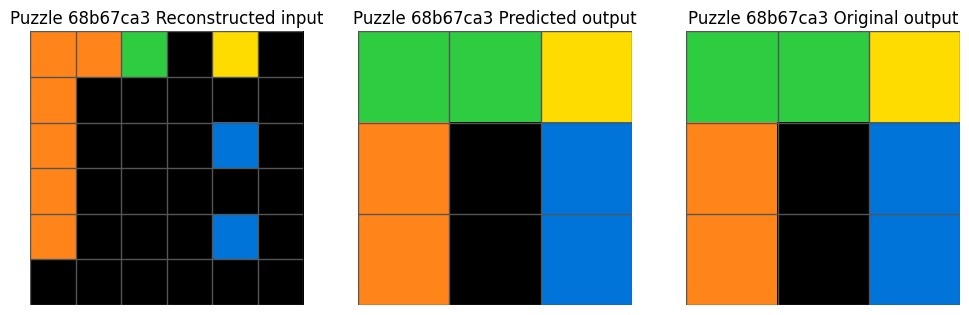

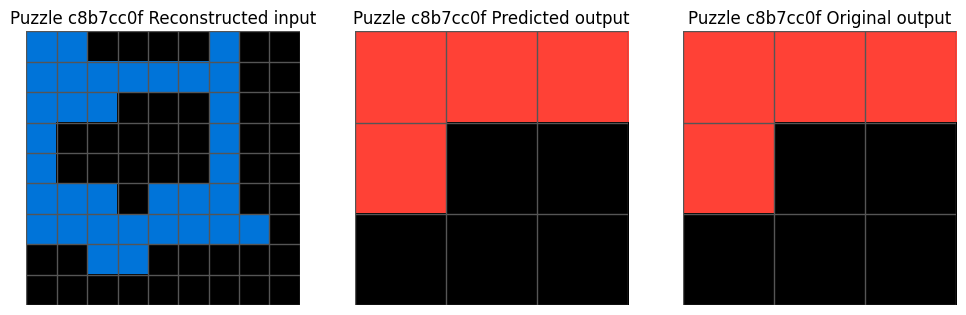

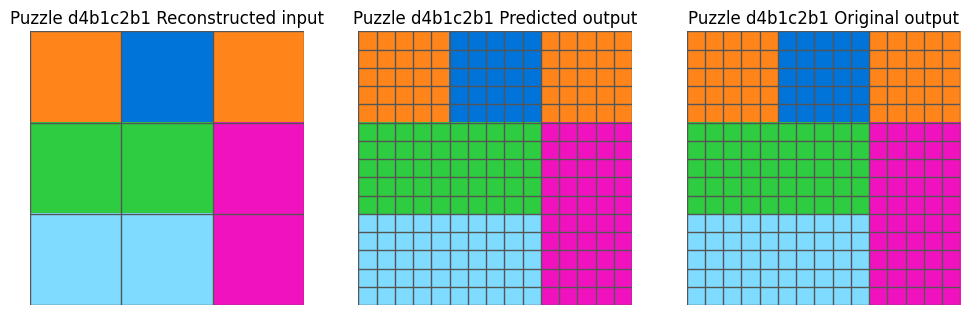

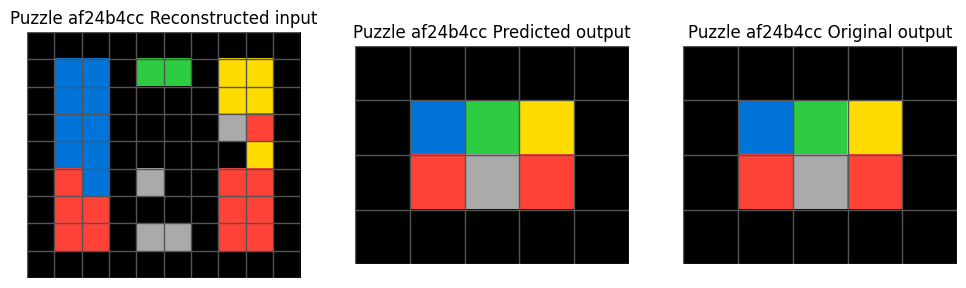

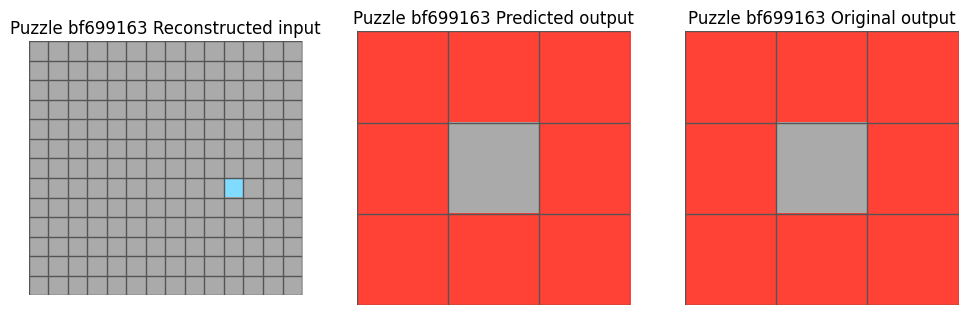

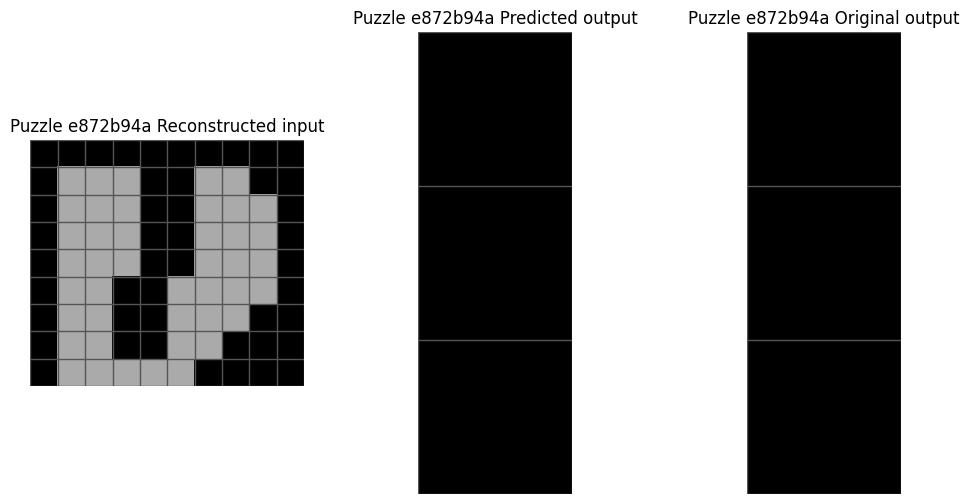

In [21]:
# counter = 0
solved_puzzles = []
for puzzle_id, task in data.items():
    # if counter >= 10:
    #     break

    # counter += 1

    Z_sol_o, Z_sol_p, Z_cons, Z_rule, Z_inp = visual_analogy_single_task(
        pipeline=pipeline,
        train_pairs=task['train'],
        test_pair=task['test'][0],
        comp='average'
    )

    if np.array_equal(Z_sol_o, Z_sol_p):
        solved_puzzles.append(puzzle_id)

        fig, axes = plt.subplots(1, 3, figsize=(12, 6))
        draw_grid(axes[0], Z_inp, f"Puzzle {puzzle_id} Reconstructed input")
        draw_grid(axes[1], Z_sol_p, f"Puzzle {puzzle_id} Predicted output")
        draw_grid(axes[2], Z_sol_o, f"Puzzle {puzzle_id} Original output")



/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_75739/489835035.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_inp = pipeline.decode(torch.tensor(z_inp, dtype=torch.float32).unsqueeze(0).to(device))
/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_75739/489835035.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_out = pipeline.decode(torch.tensor(z_out, dtype=torch.float32).unsqueeze(0).to(device))


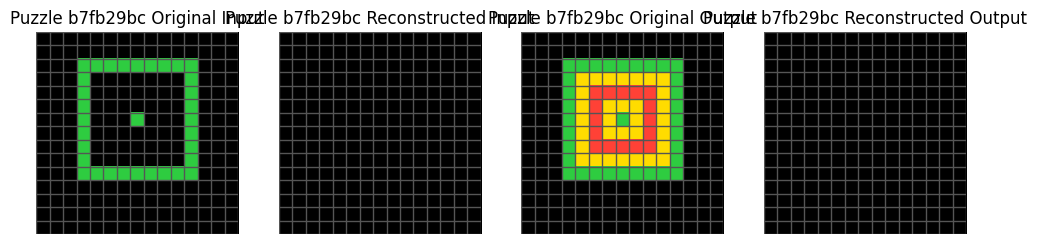

In [5]:
key='b7fb29bc'
pair = [([pair for pairs in data[key].values() for pair in pairs])[0]]
for (input, output) in pair:
    orig_input = input.copy()
    orig_output = output.copy()
    input = pipeline.preprocess_and_compress(input)
    output = pipeline.preprocess_and_compress(output)
    z_inp, _ = pipeline.encode(input.unsqueeze(0).to(device))
    z_out, _ = pipeline.encode(output.unsqueeze(0).to(device))

    x_inp = pipeline.decode(torch.tensor(z_inp, dtype=torch.float32).unsqueeze(0).to(device))
    x_inp = pipeline.decompress_and_postprocess(x_inp, orig_input)

    x_out = pipeline.decode(torch.tensor(z_out, dtype=torch.float32).unsqueeze(0).to(device))
    x_out = pipeline.decompress_and_postprocess(x_out, orig_output)
    
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))
    draw_grid(axes[0], orig_input, f"Puzzle {key} Original Input")
    draw_grid(axes[1], x_inp, f"Puzzle {key} Reconstructed Input")
    draw_grid(axes[2], orig_output, f"Puzzle {key} Original Output")
    draw_grid(axes[3], x_out, f"Puzzle {key} Reconstructed Output")

In [7]:
print(len(solved_puzzles))

1


/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_73170/3860315878.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(12, 6))


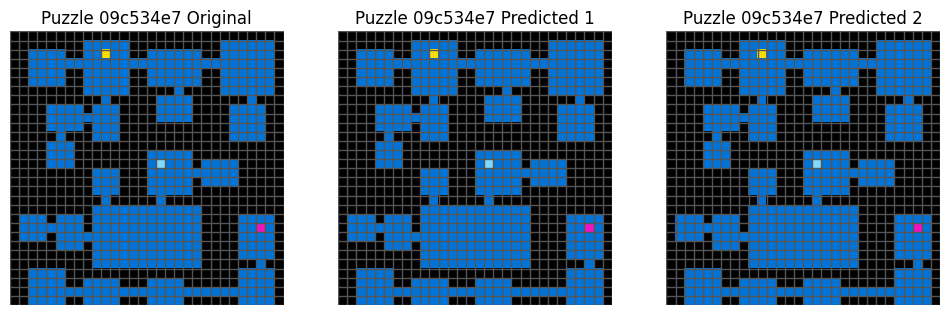

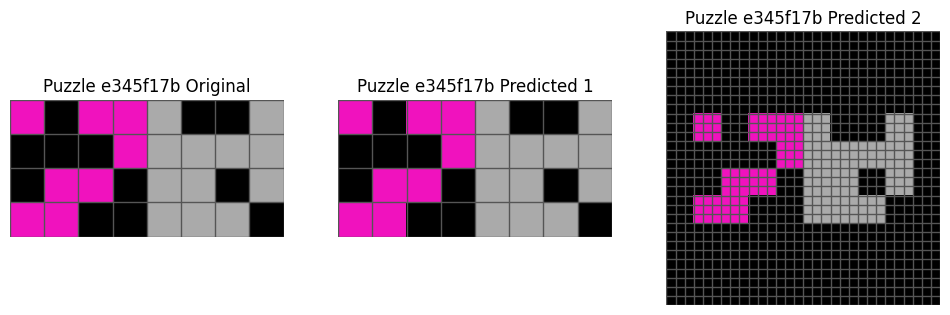

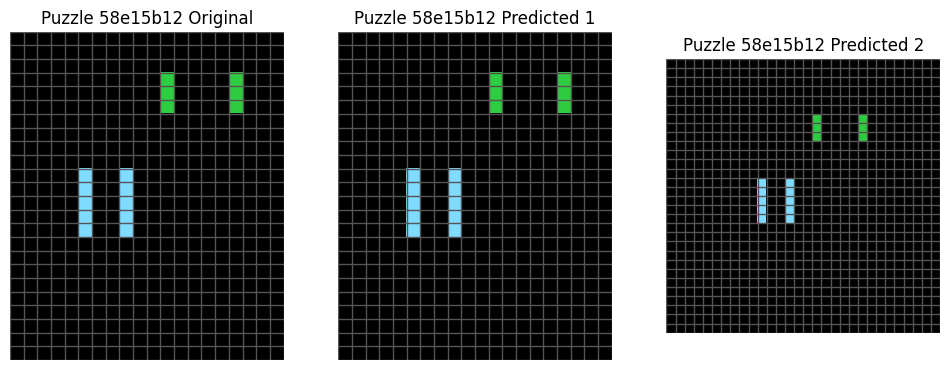

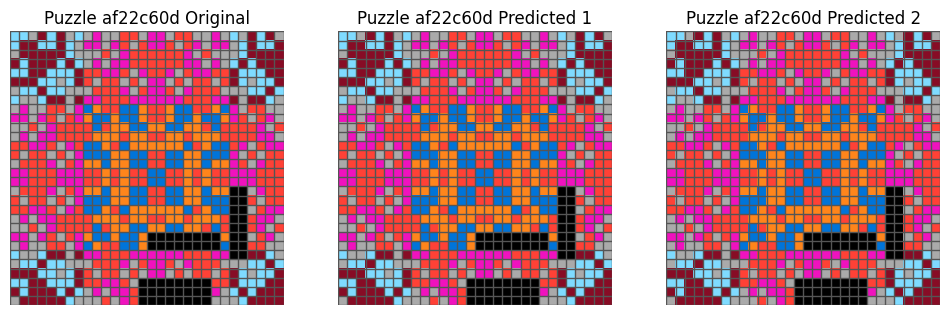

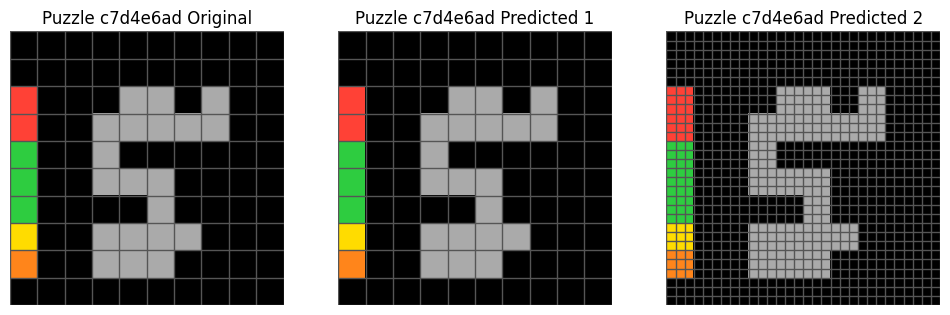

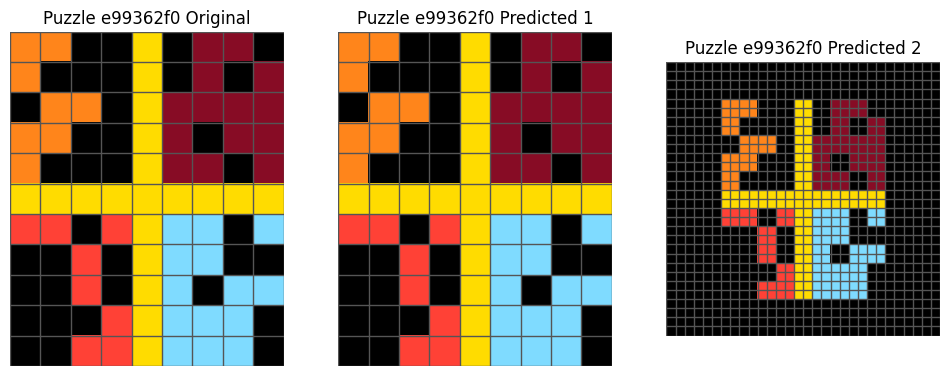

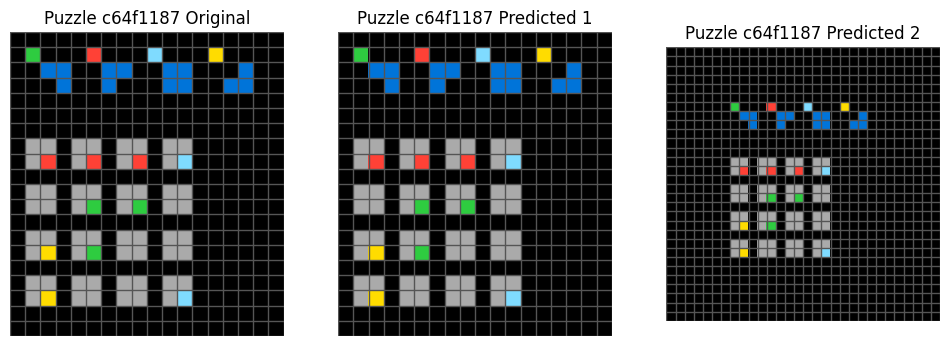

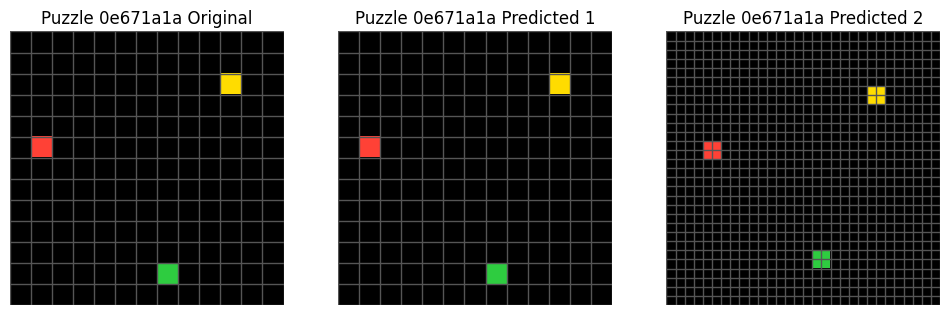

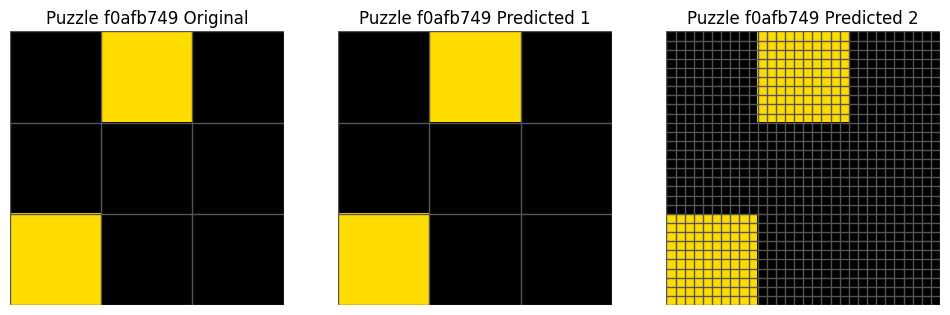

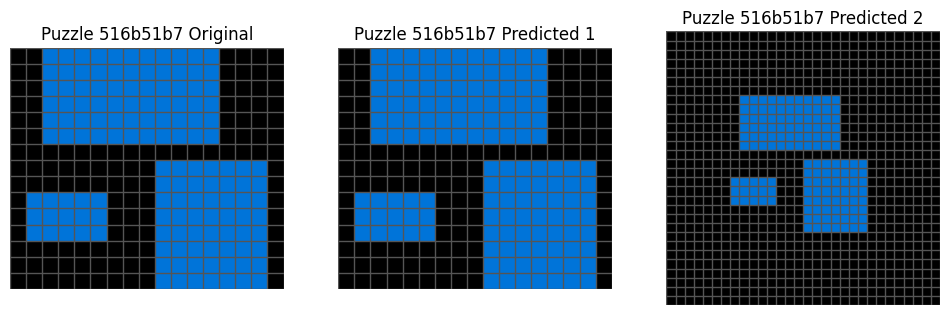

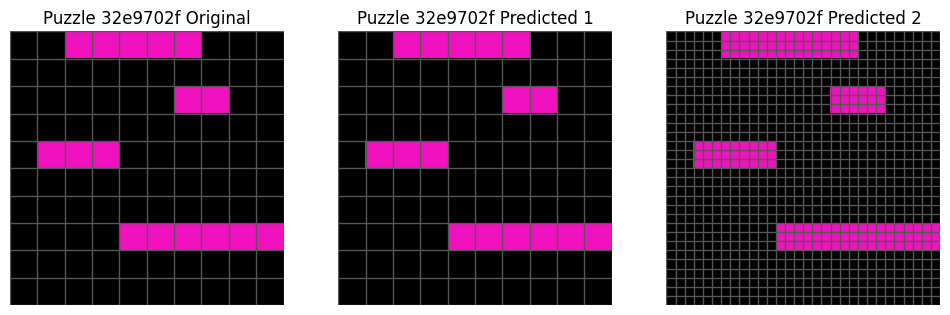

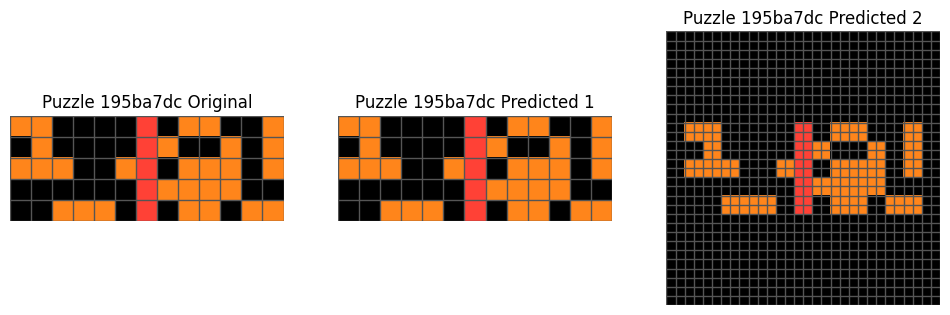

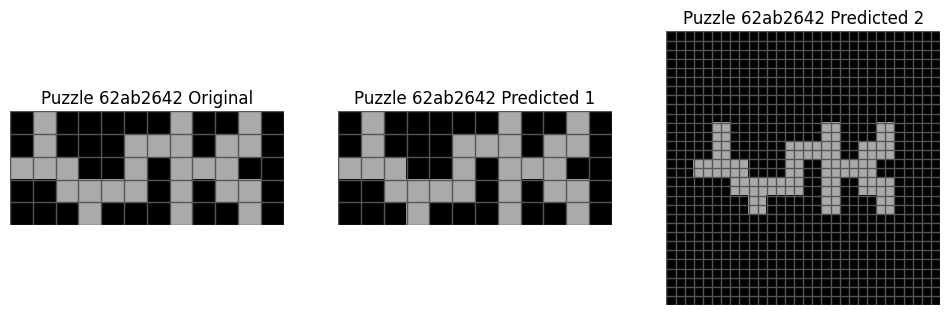

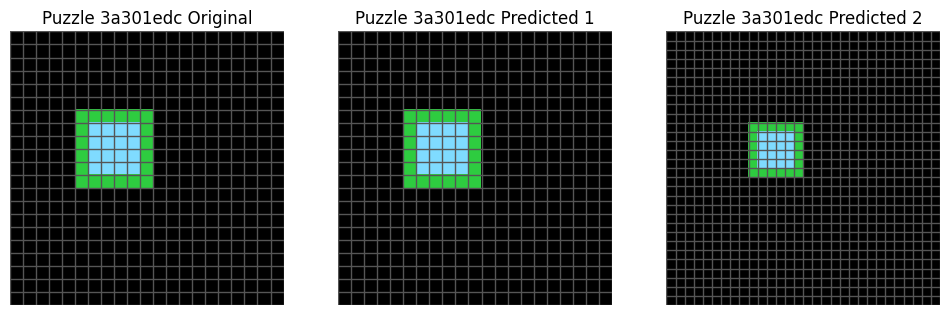

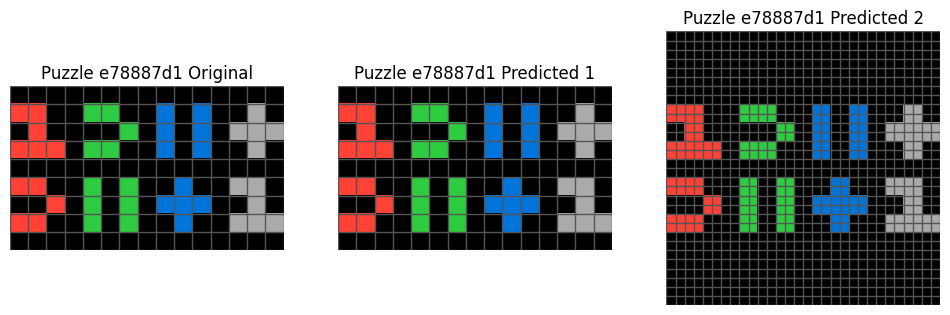

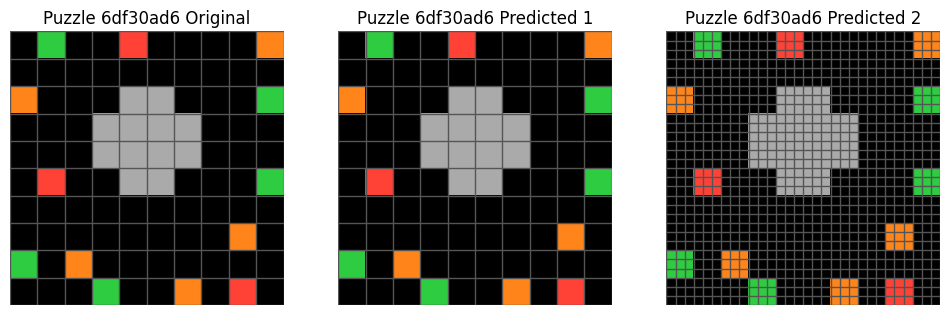

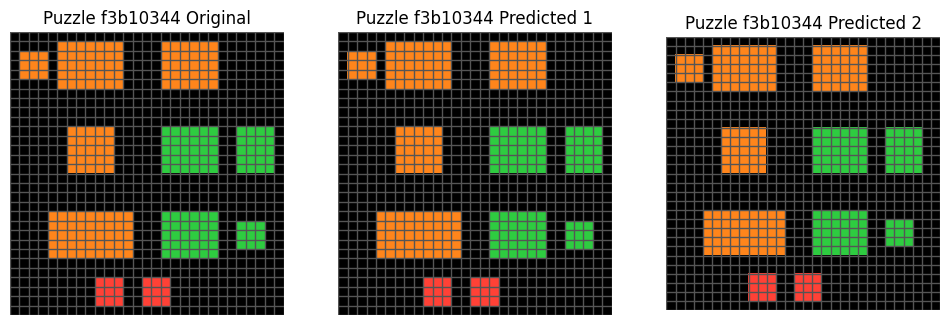

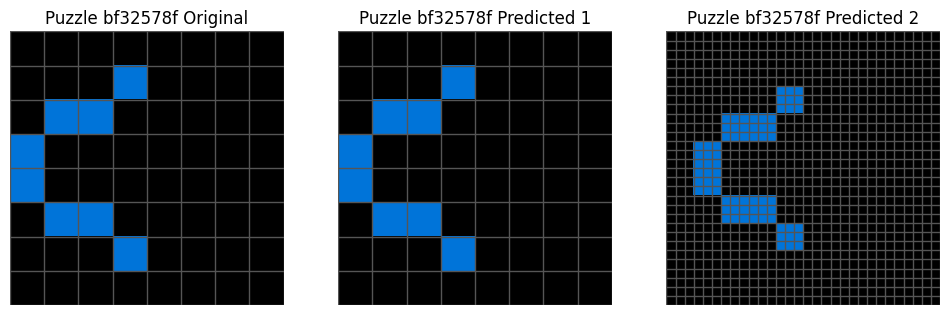

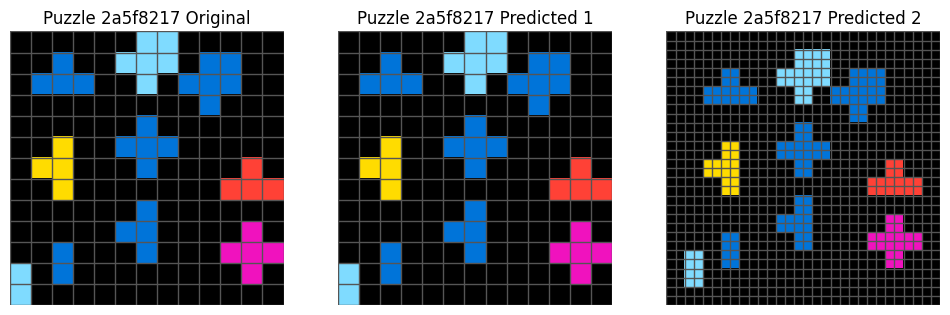

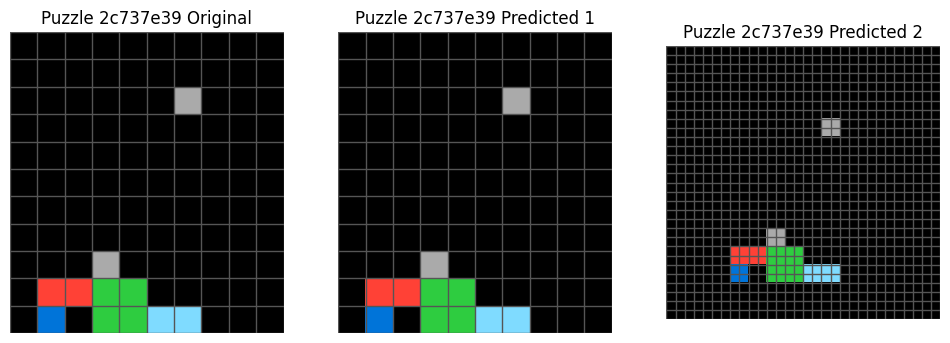

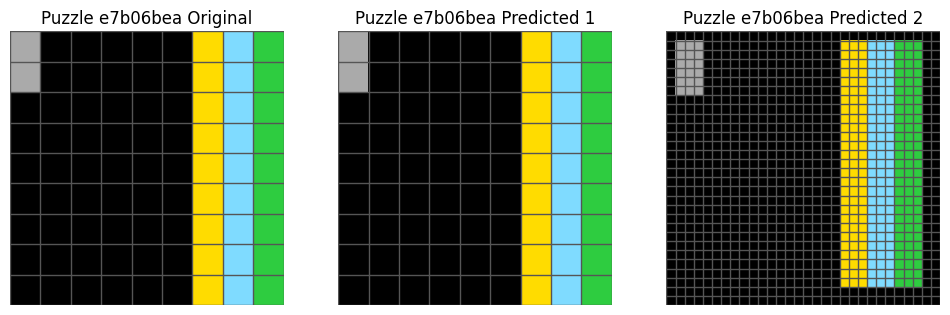

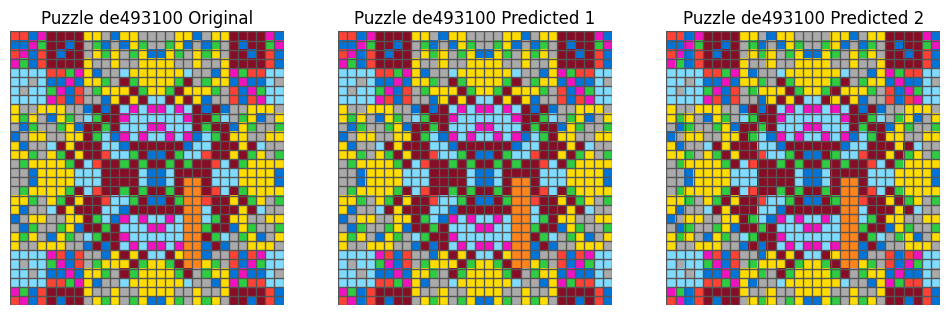

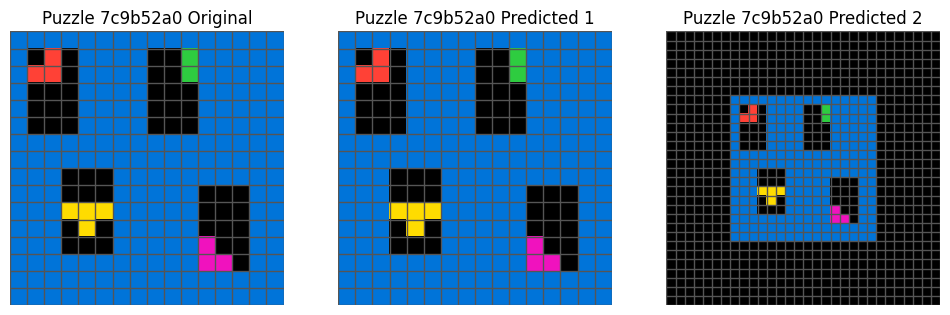

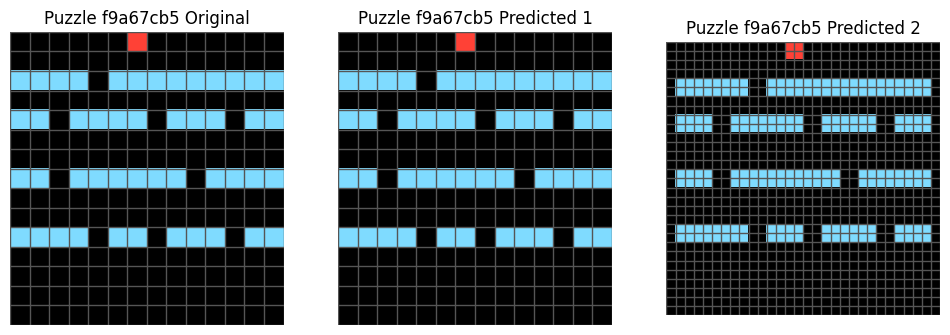

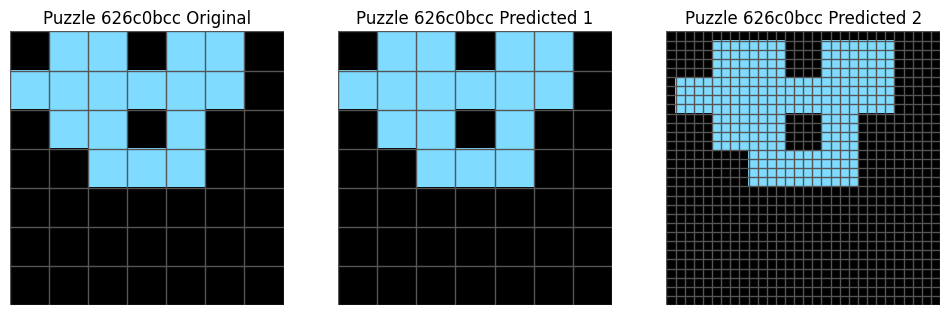

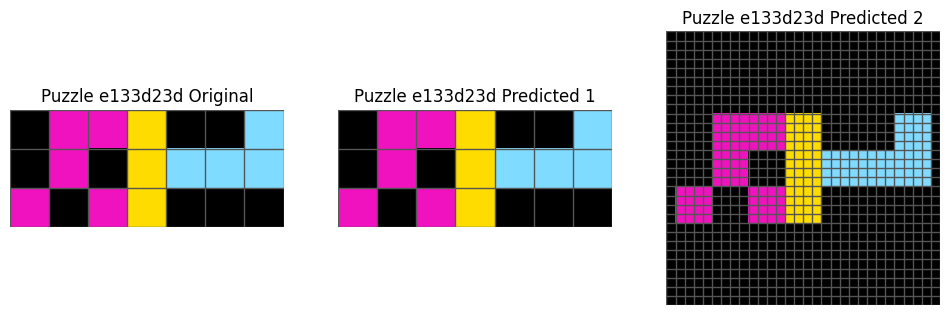

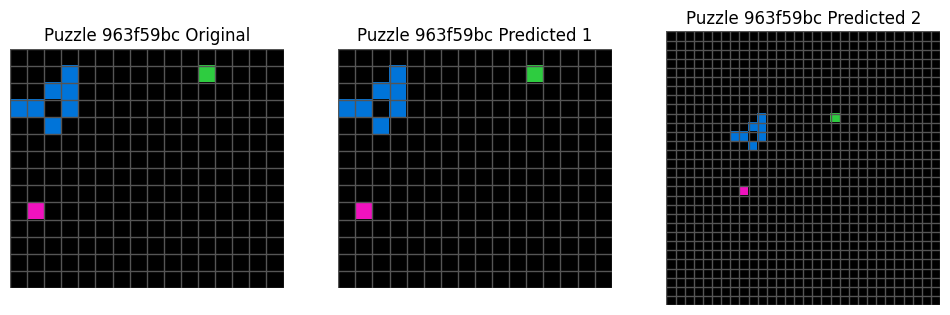

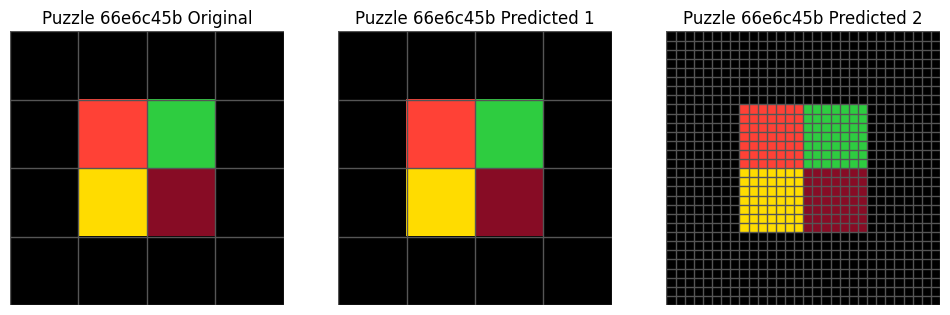

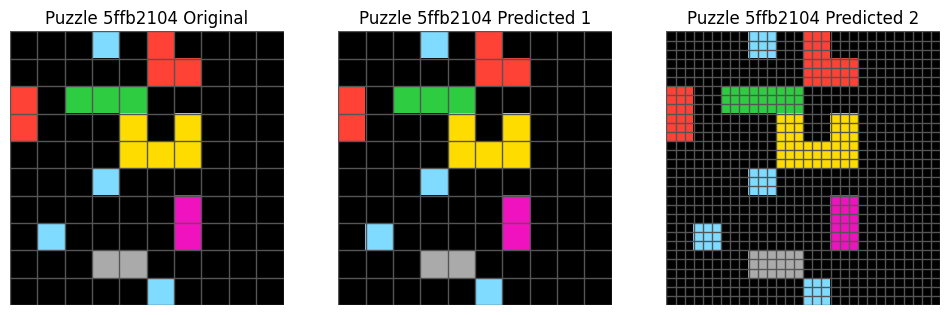

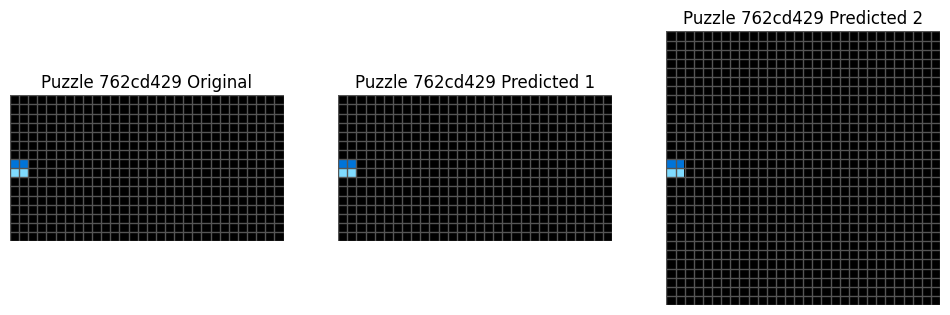

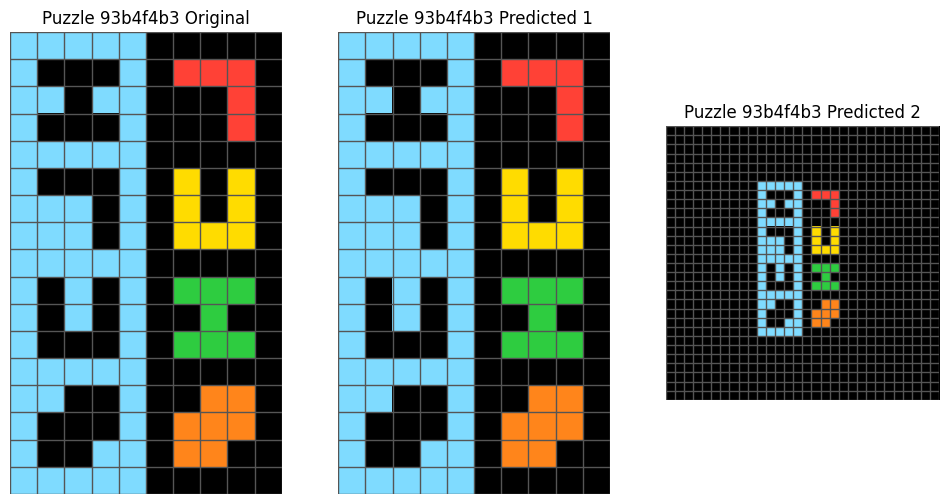

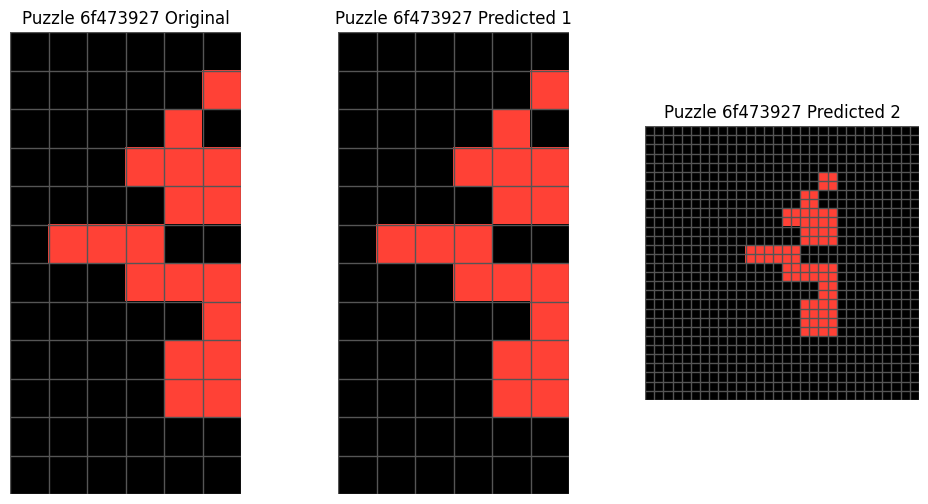

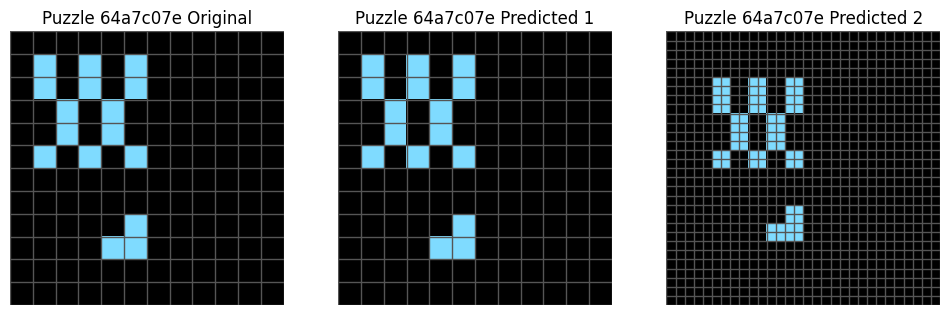

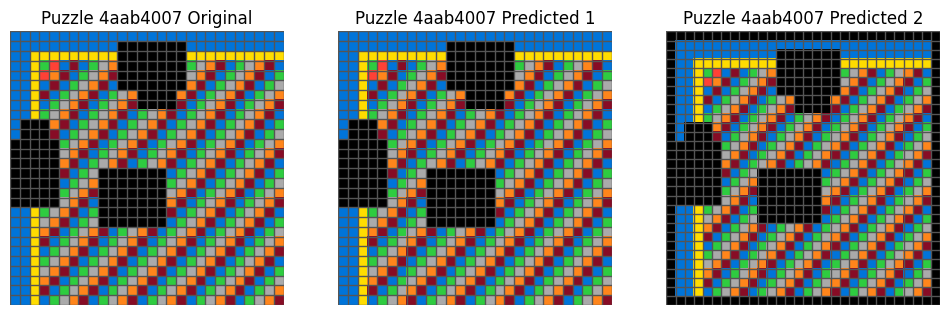

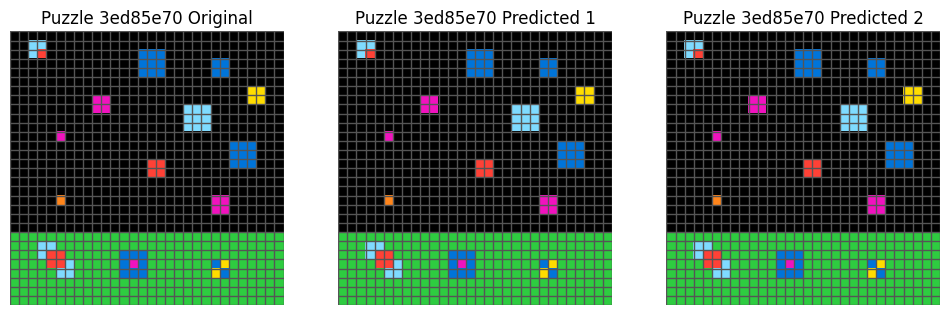

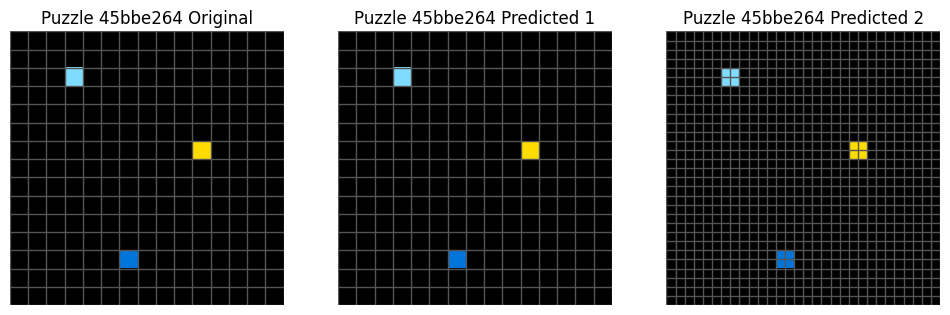

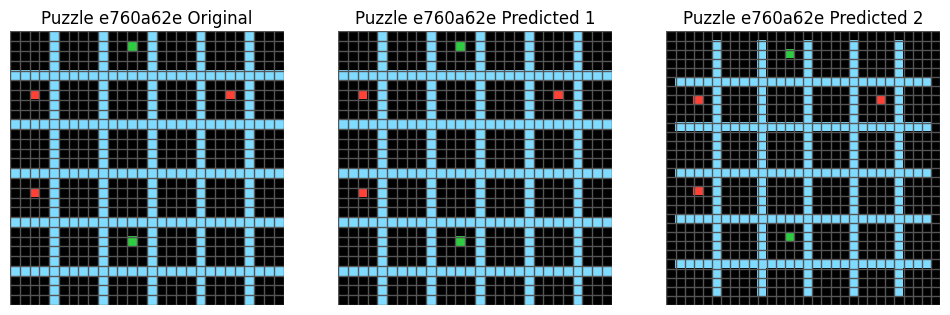

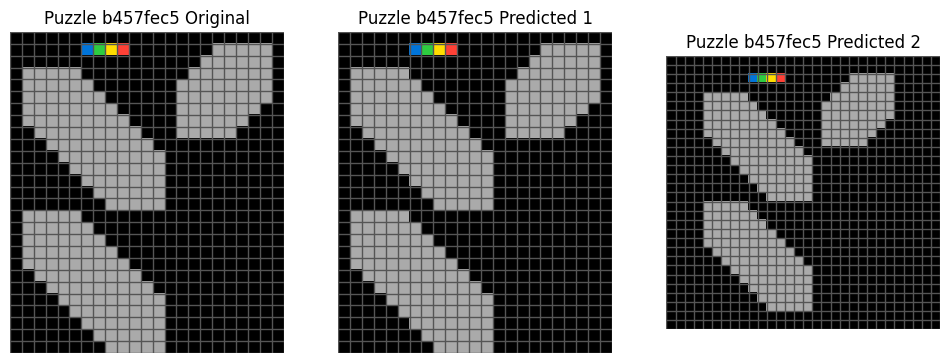

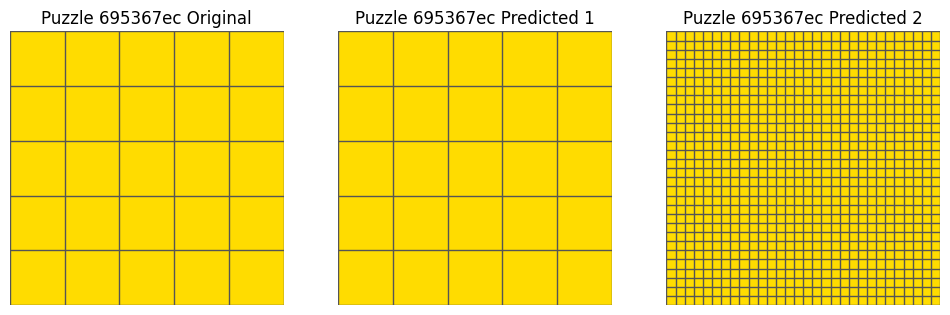

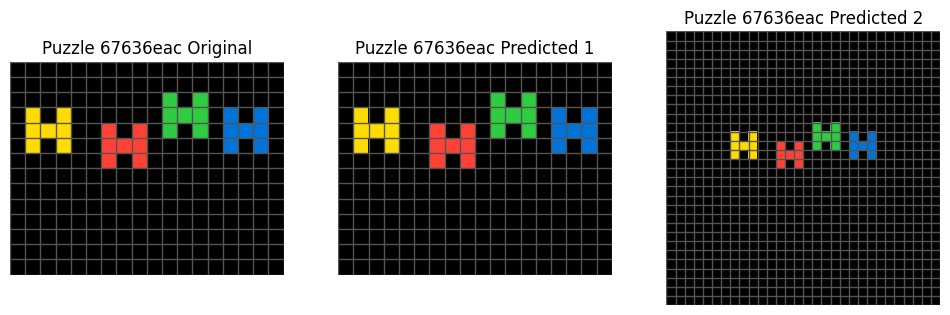

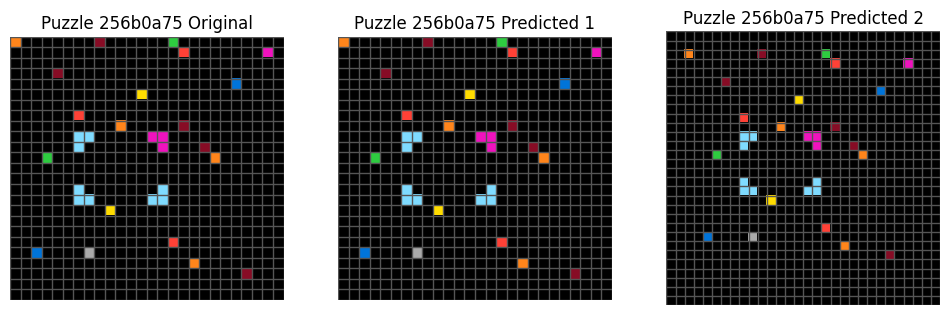

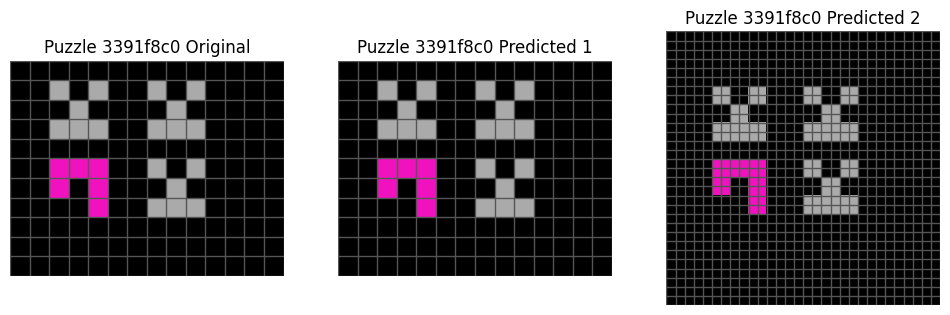

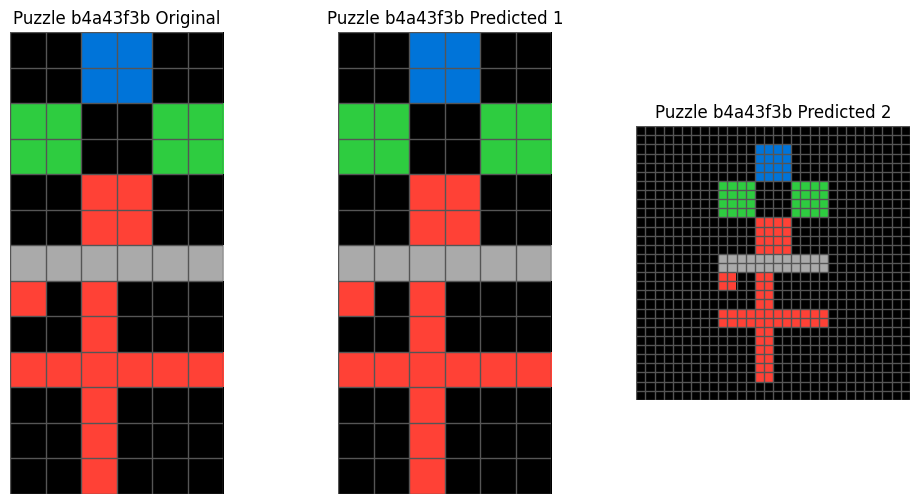

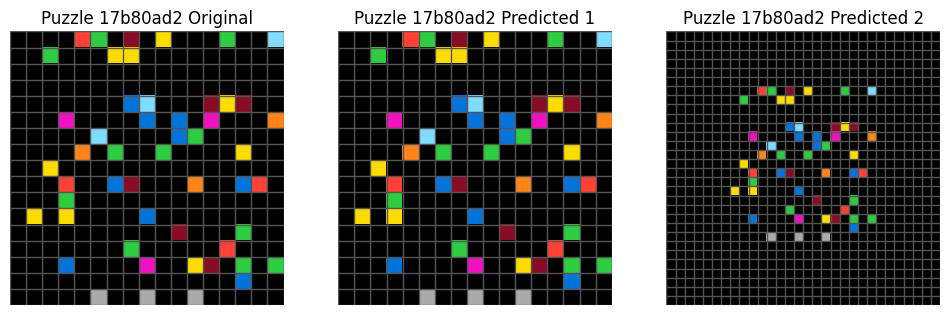

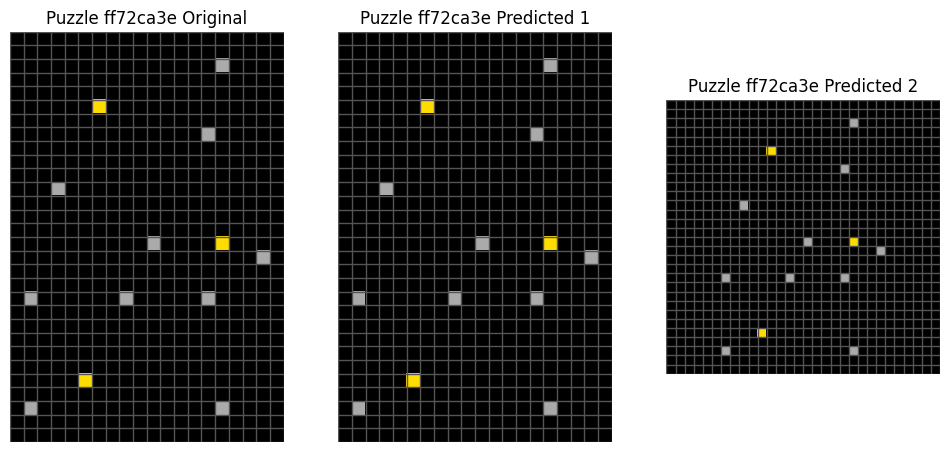

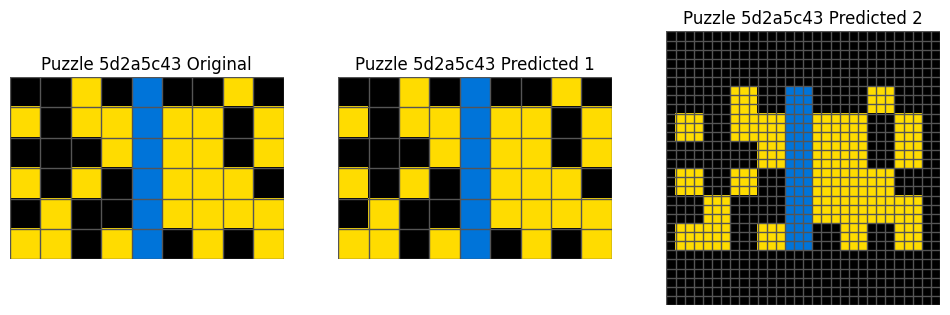

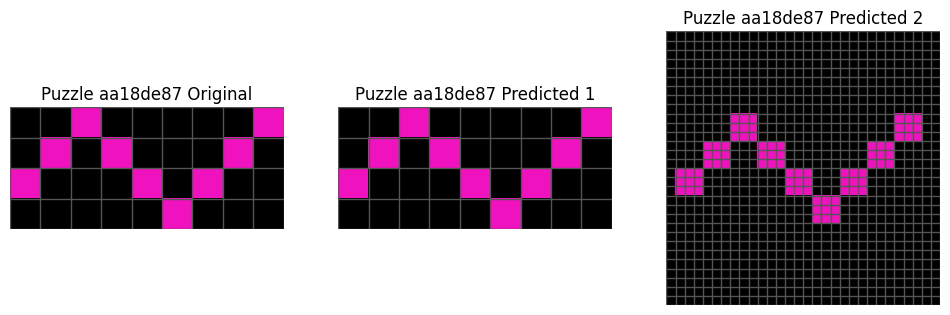

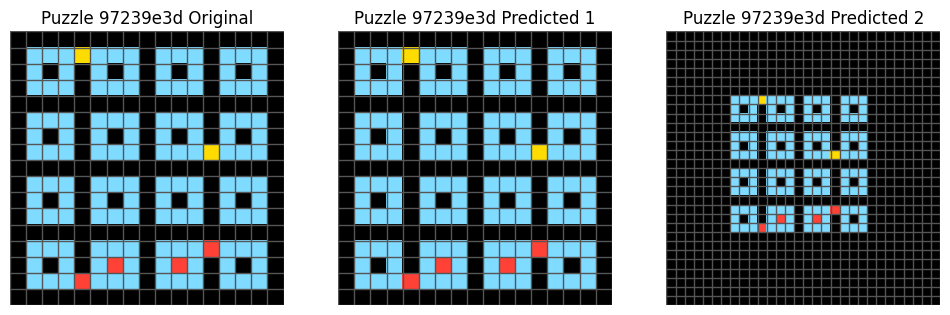

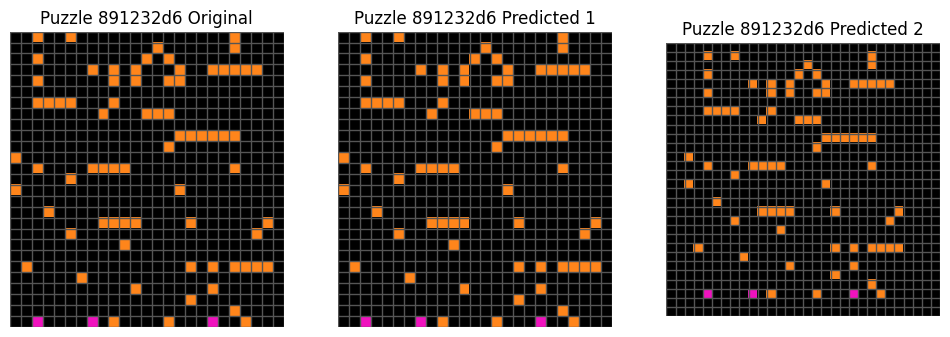

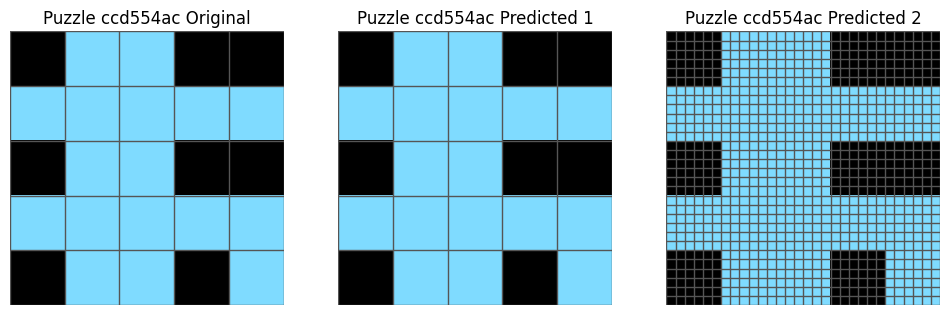

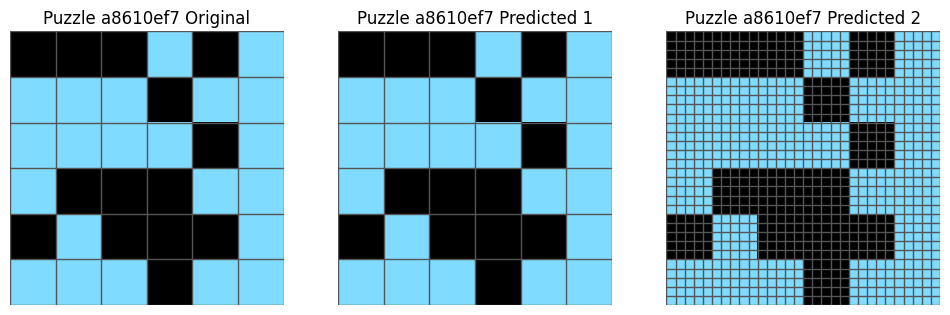

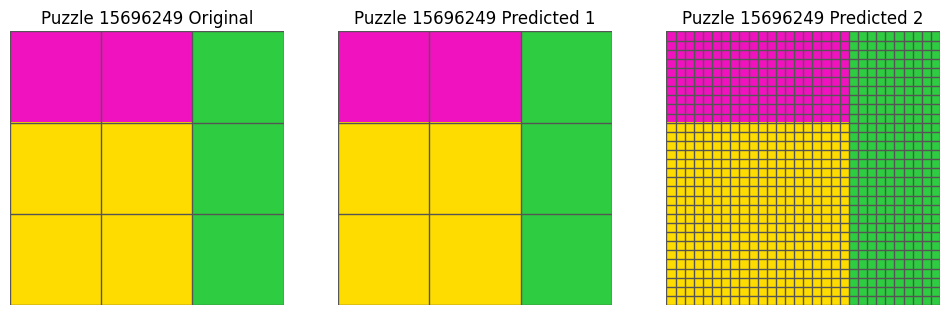

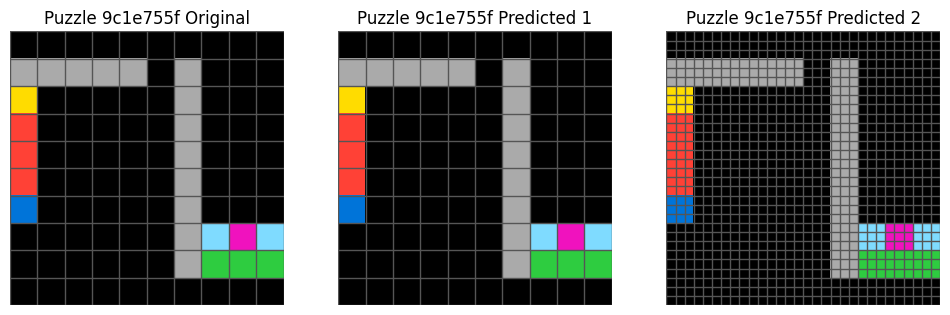

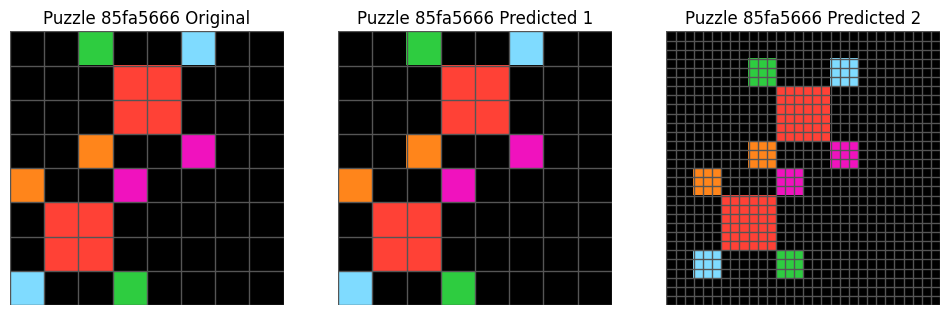

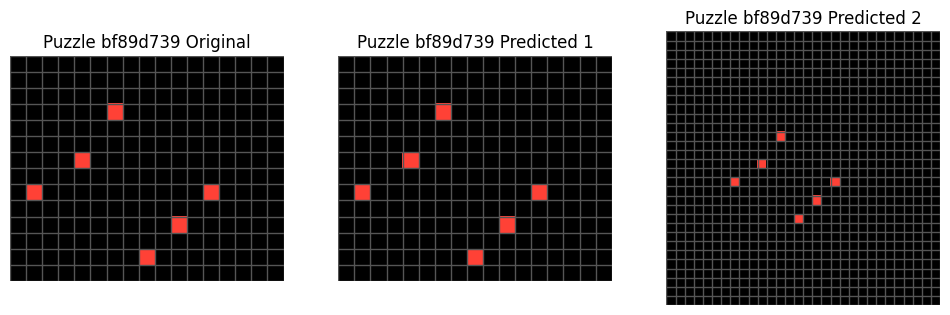

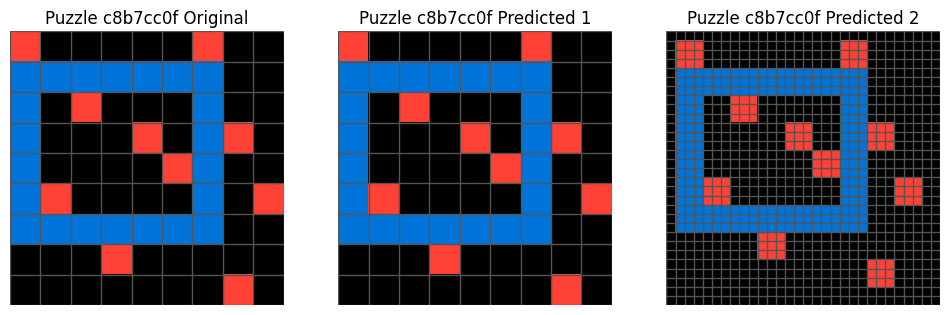

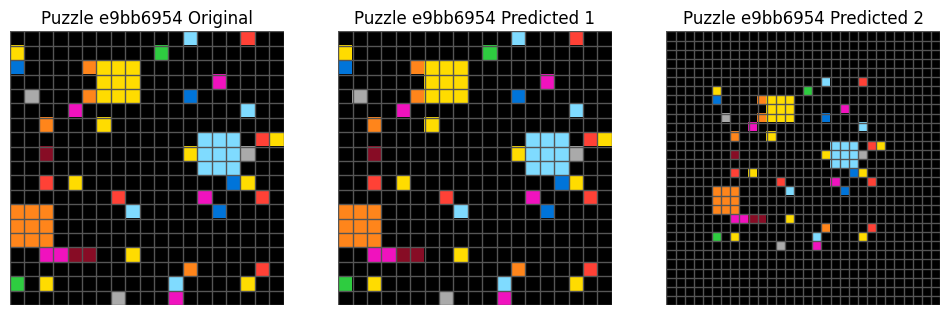

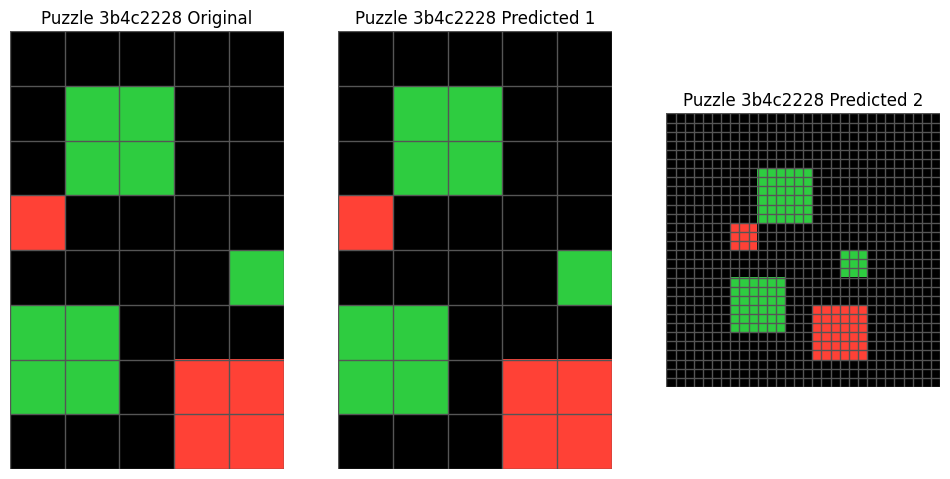

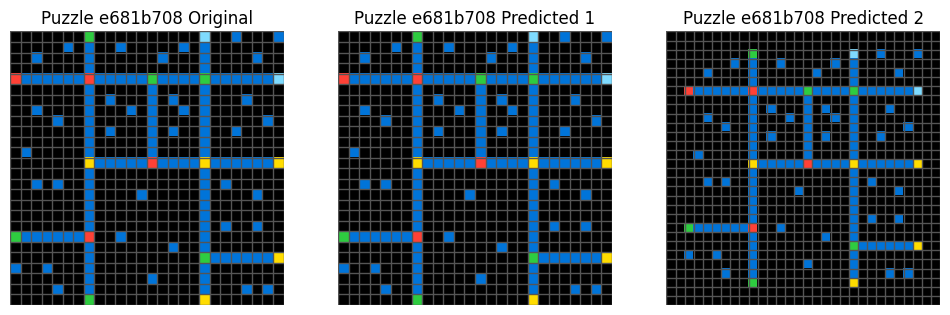

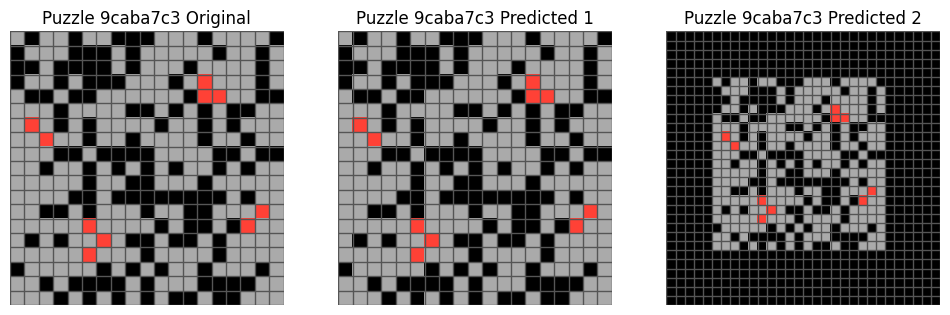

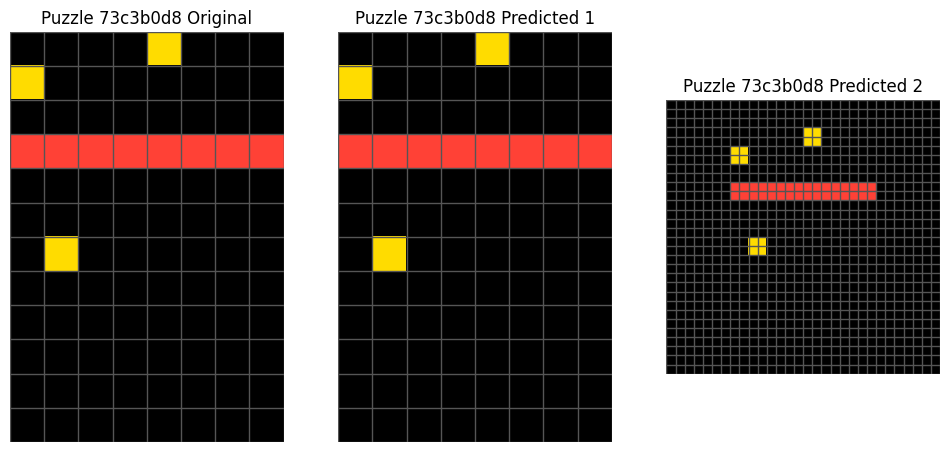

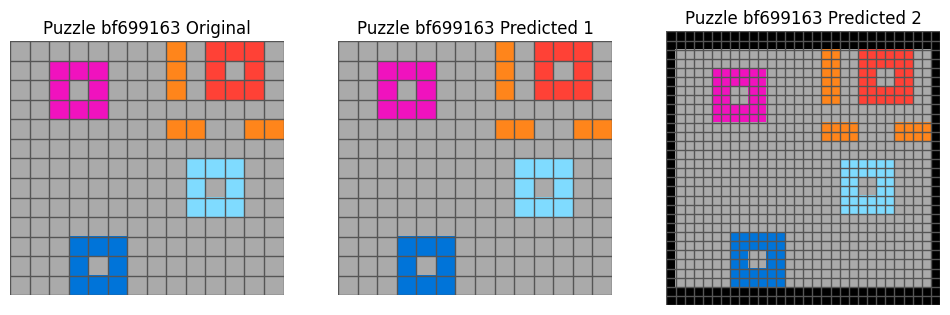

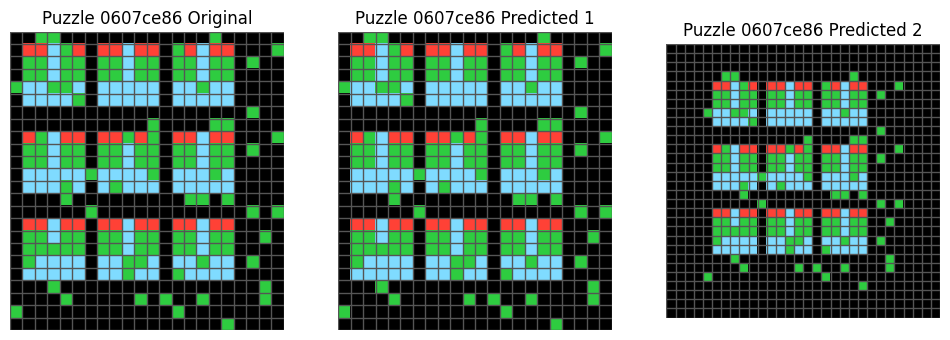

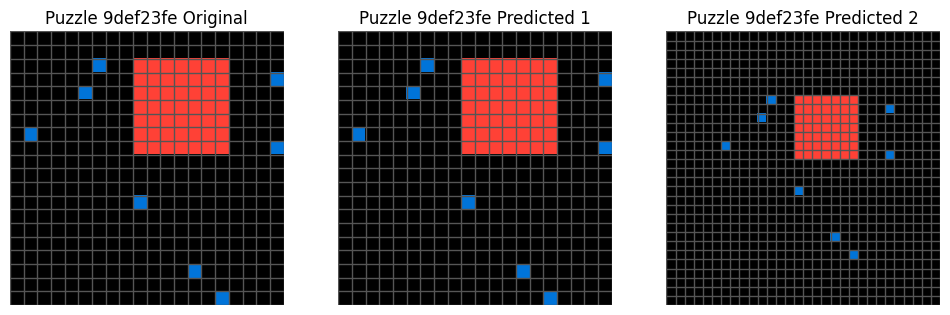

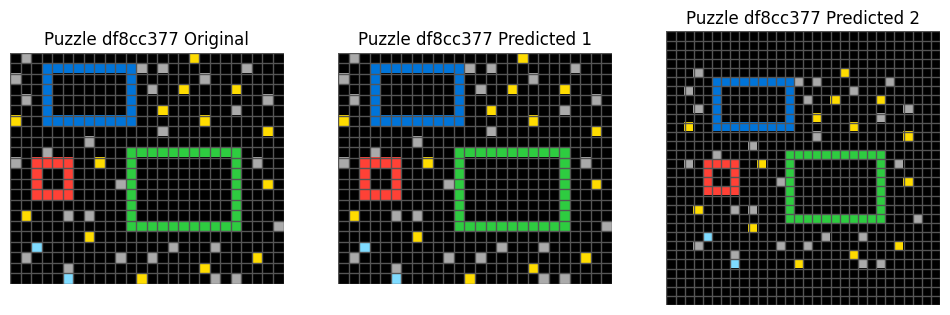

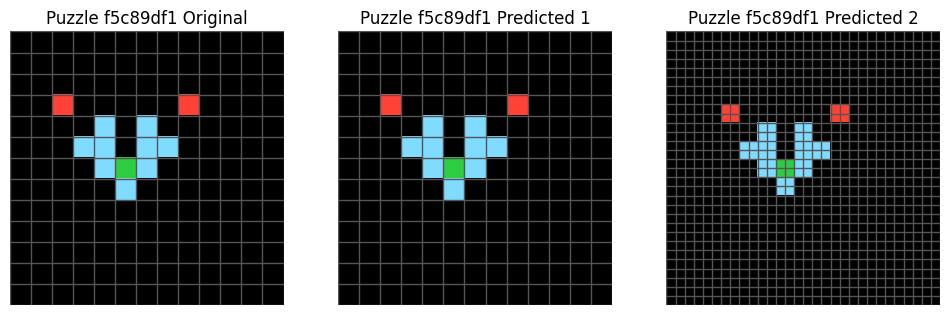

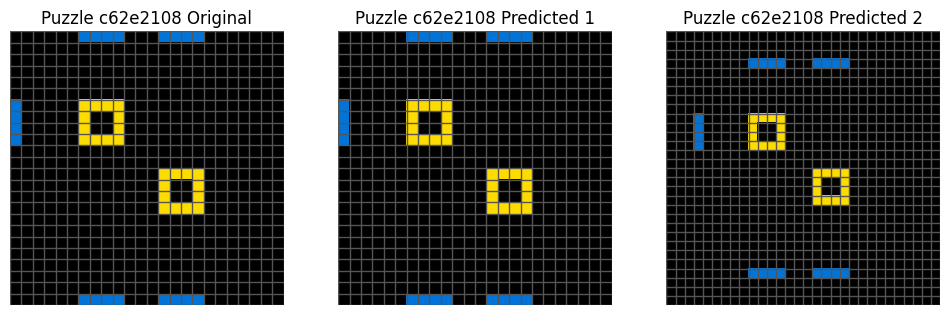

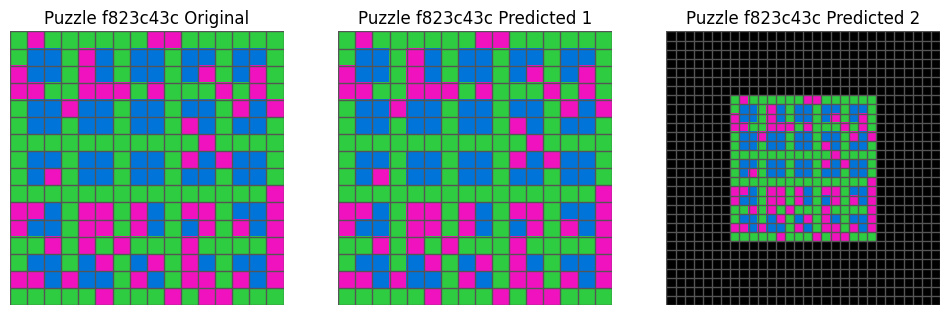

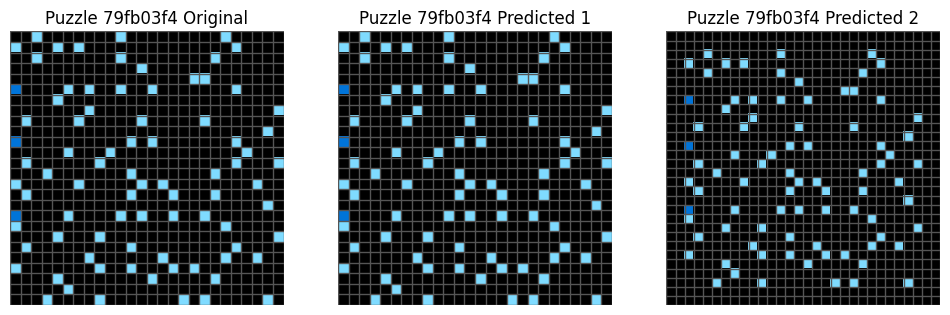

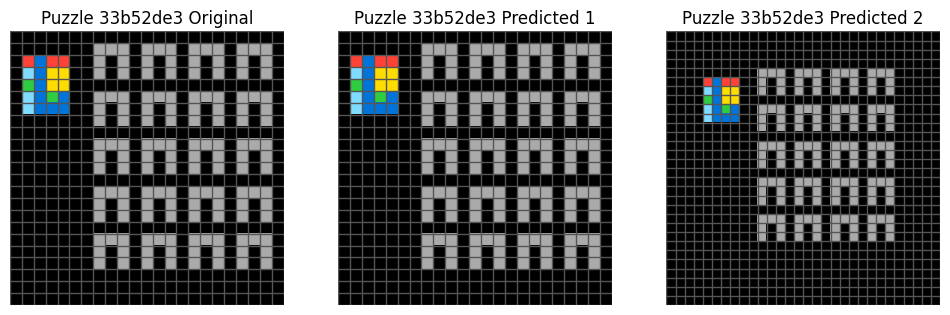

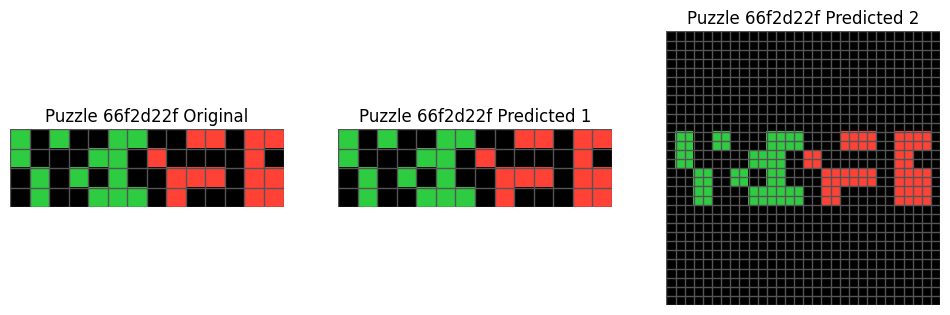

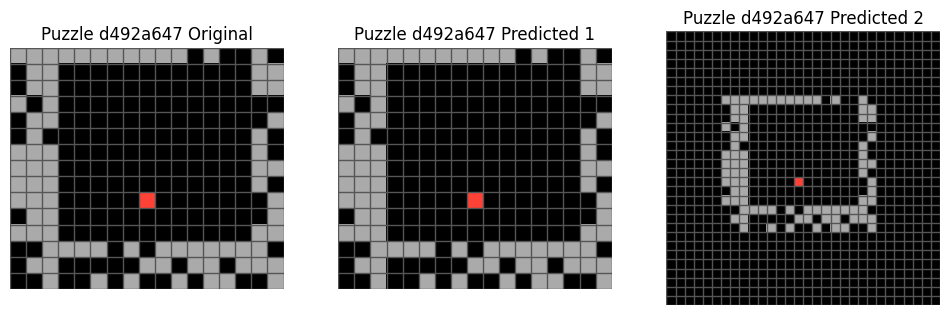

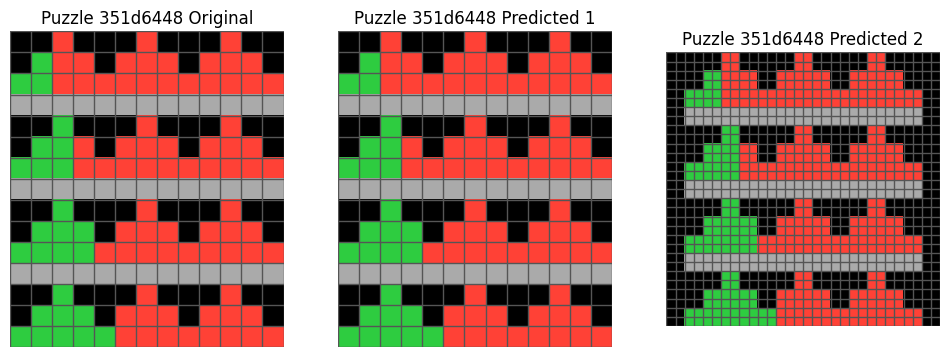

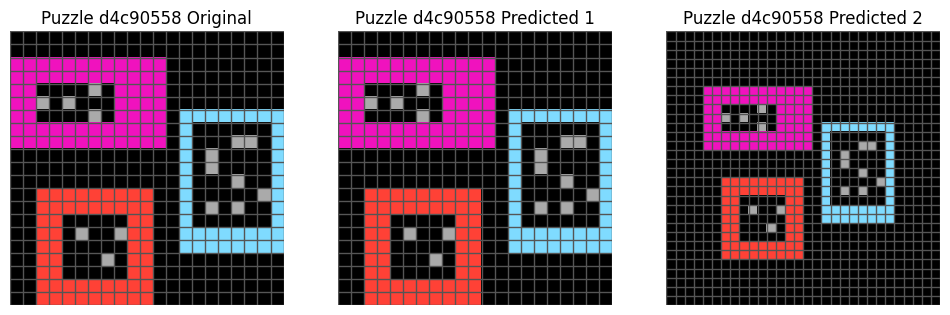

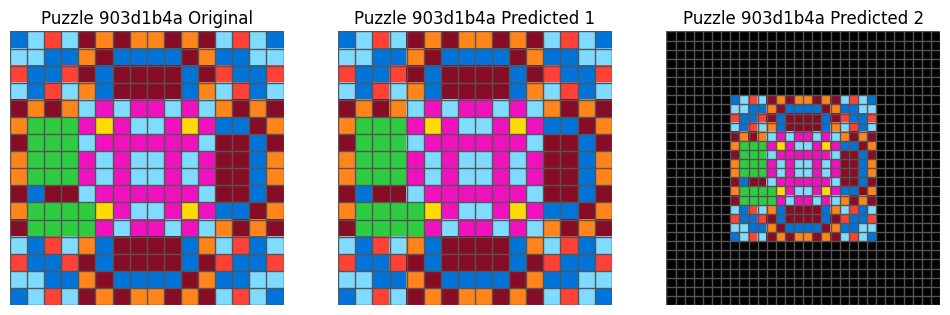

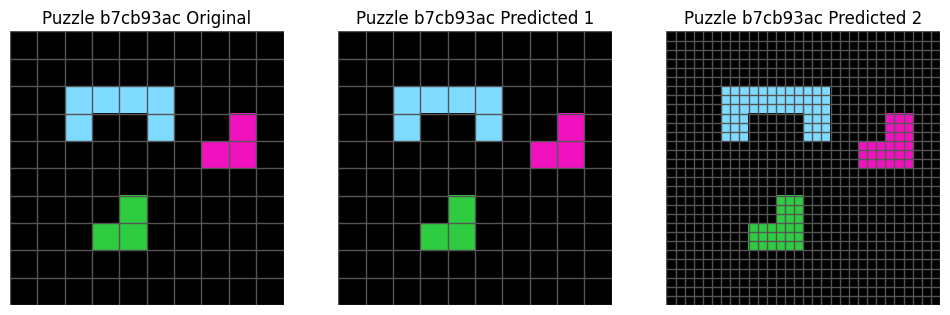

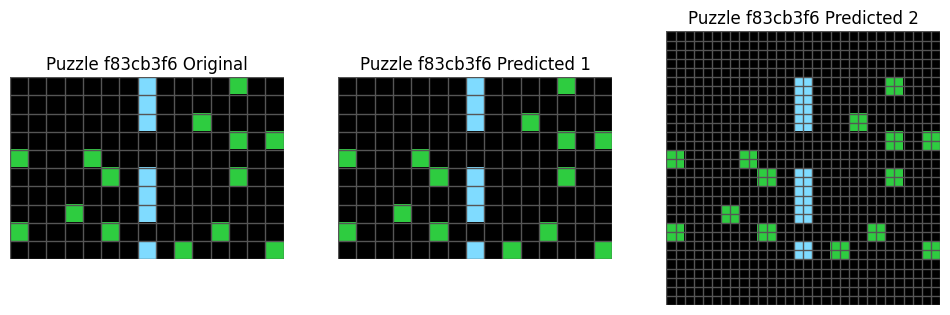

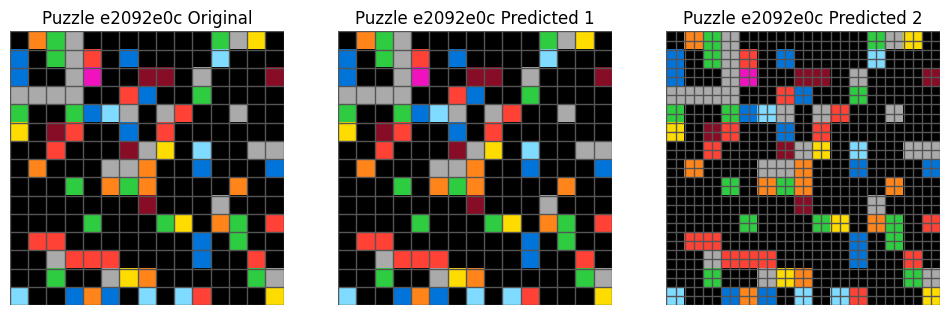

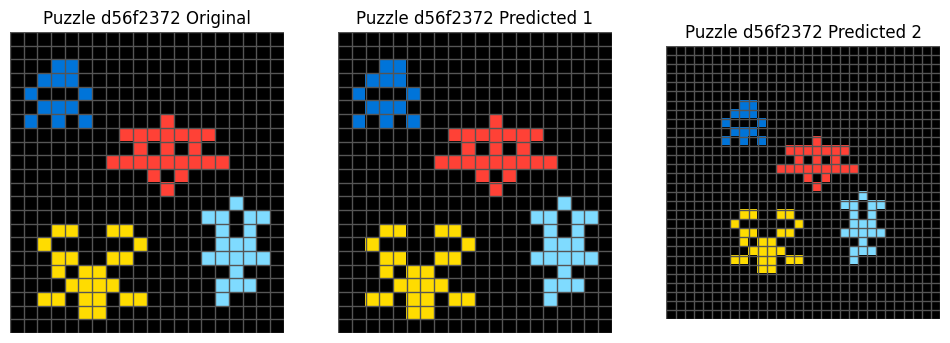

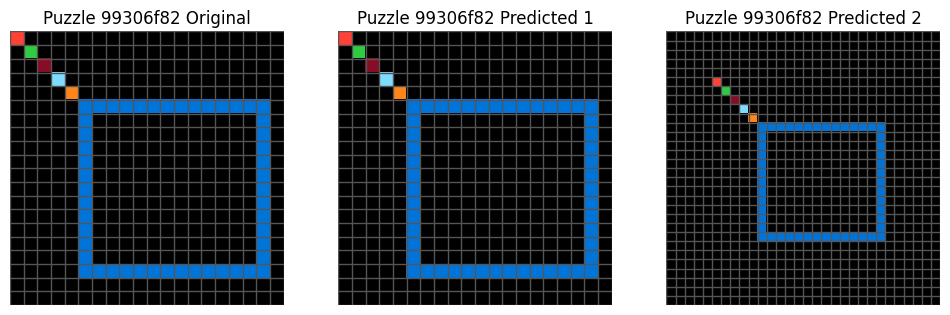

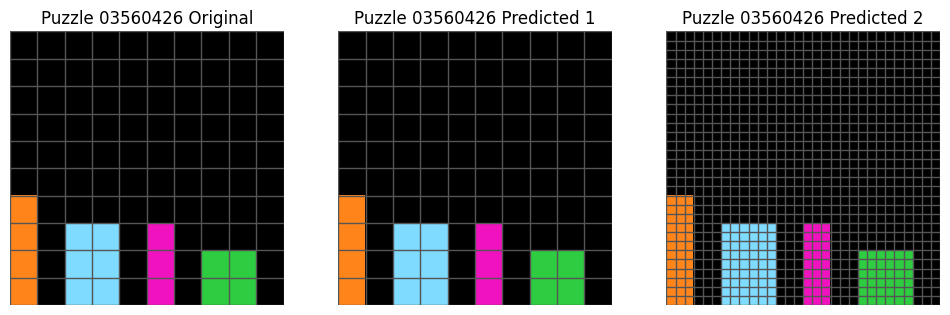

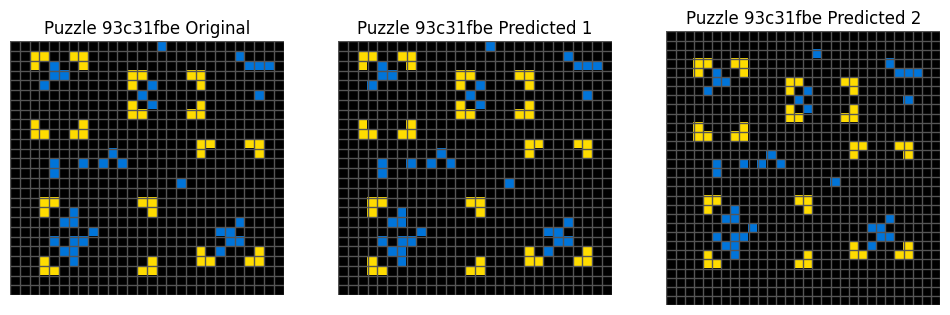

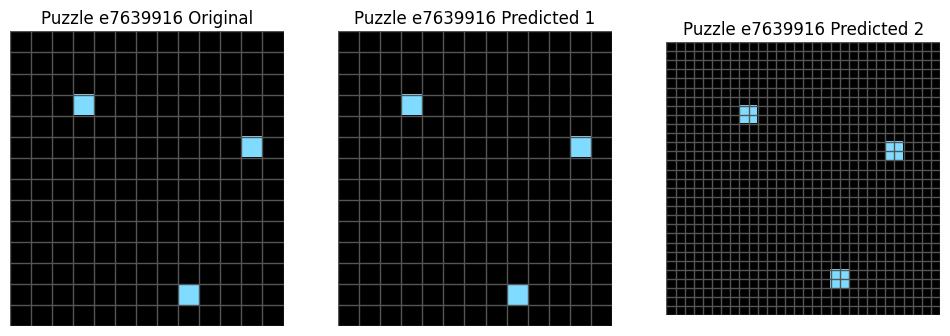

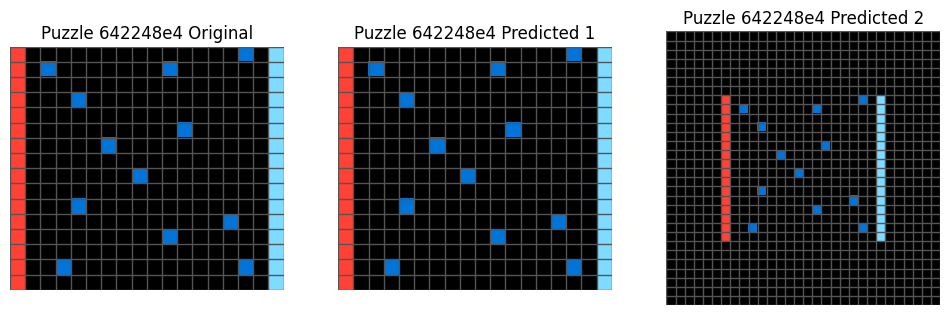

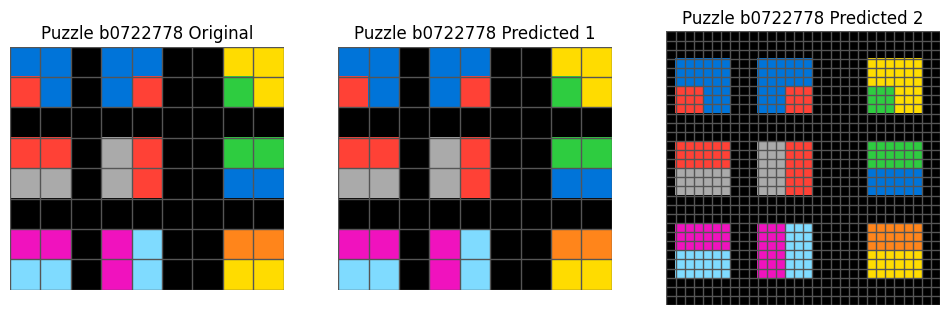

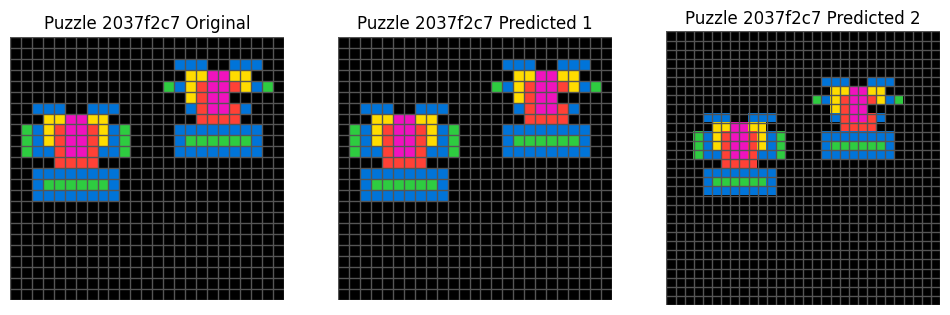

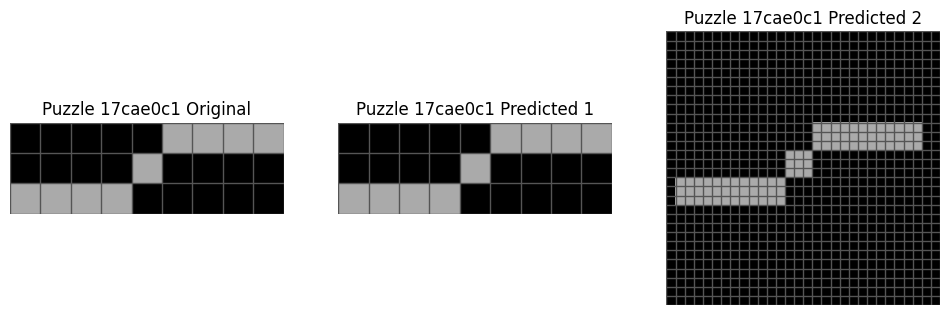

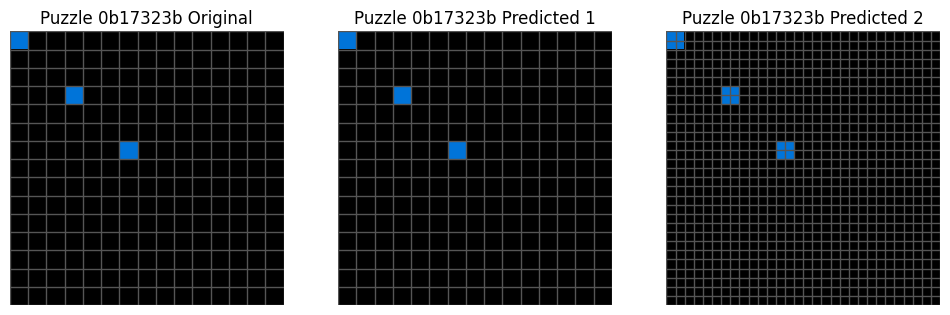

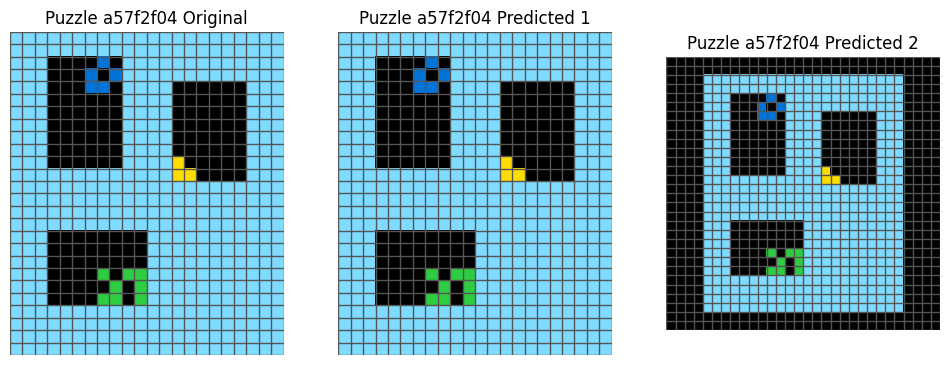

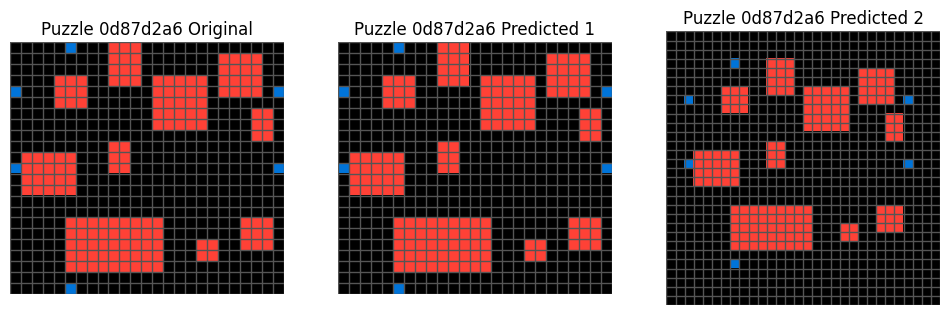

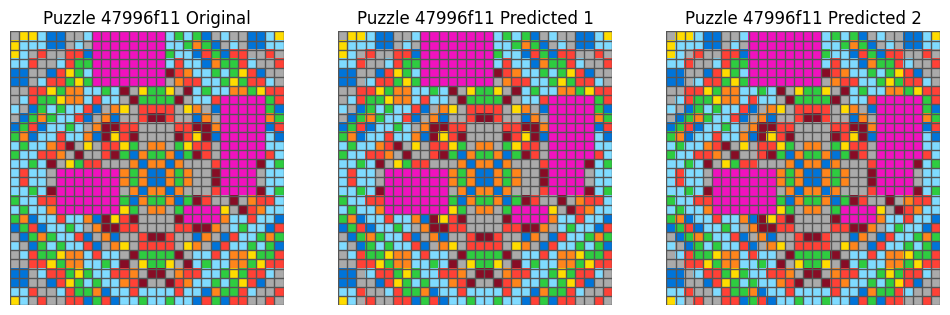

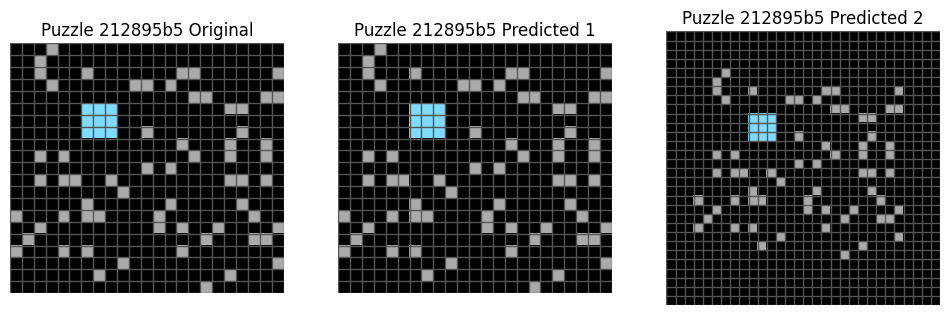

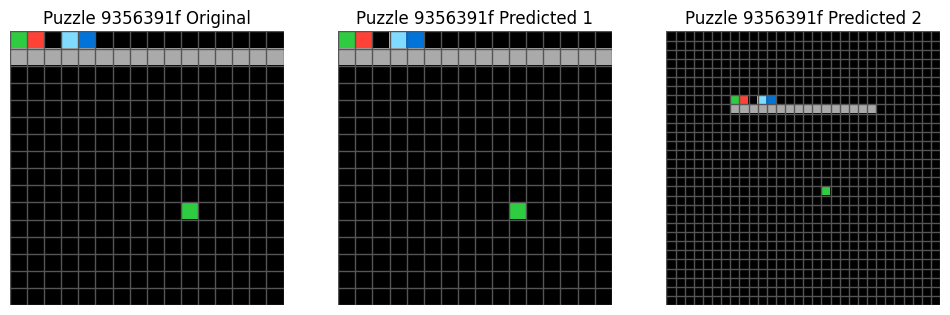

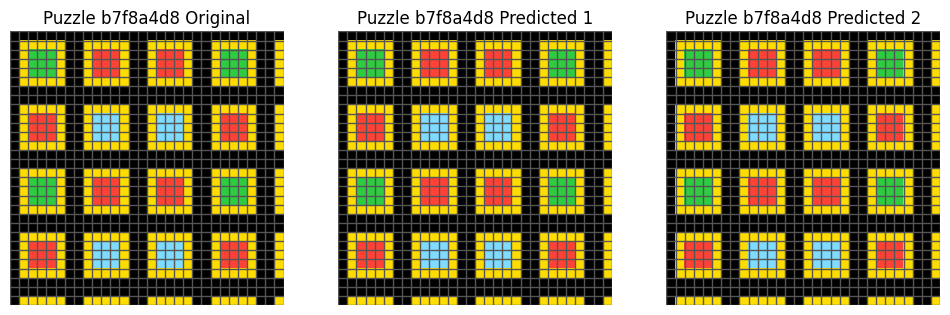

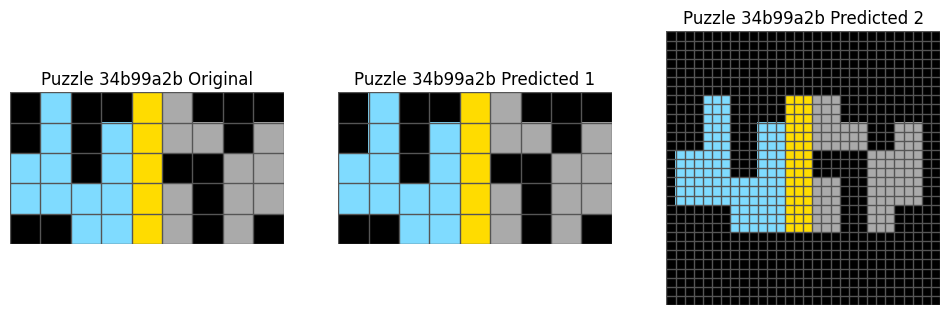

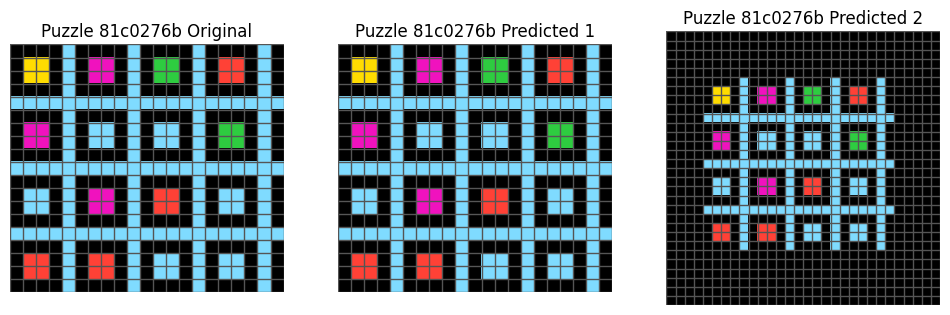

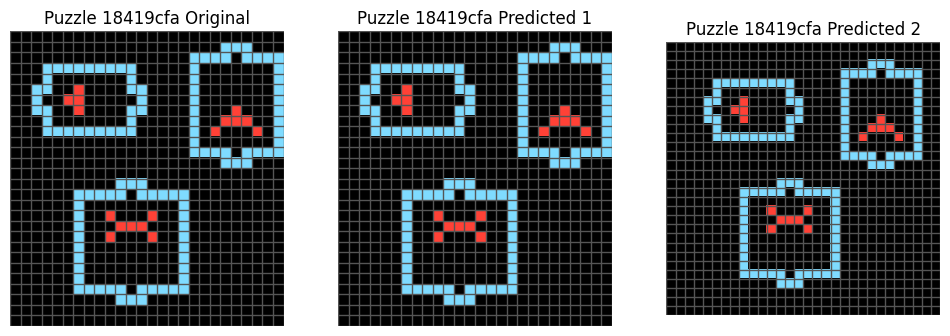

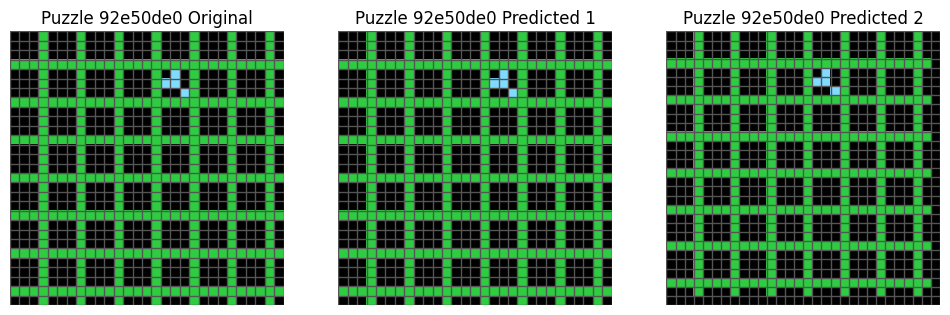

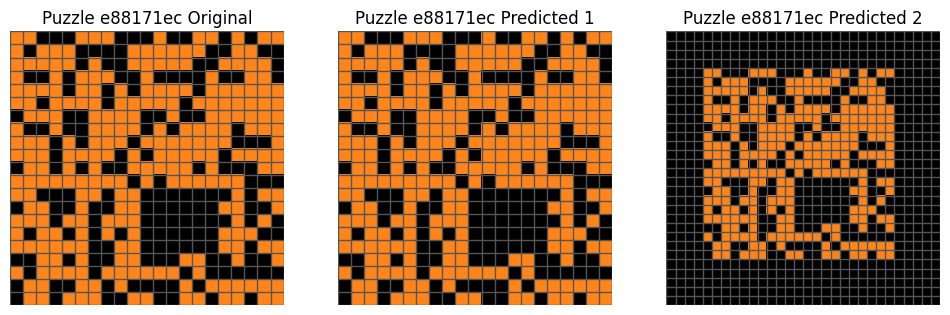

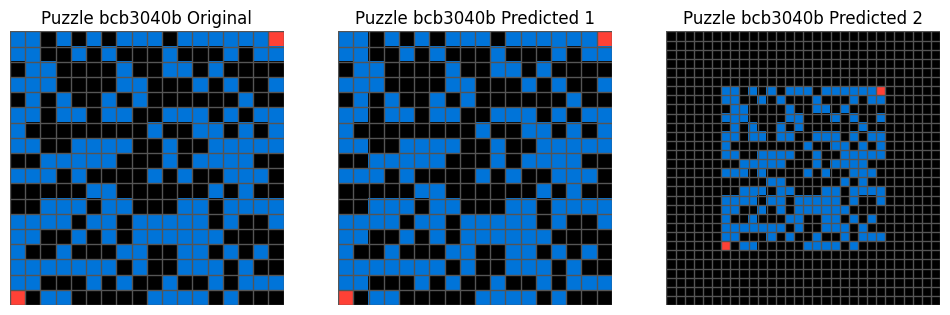

In [4]:
counter = 0
for puzzle_id, task in data.items():
    if counter >= 100:
        break

    test_pair = task['test'][0]
    
    counter += 1

    input_q, _ = test_pair

    input_w1 = pipeline.decompress_and_postprocess(pipeline.preprocess_and_compress(input_q), input_q)
    input_w2 = decompress_wavelet(compress_wavelet(preprocess_grid(input_q)))
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    draw_grid(axes[0], input_q, f"Puzzle {puzzle_id} Original")
    draw_grid(axes[1], input_w1, f"Puzzle {puzzle_id} Predicted 1")
    draw_grid(axes[2], input_w2, f"Puzzle {puzzle_id} Predicted 2")

